# DAT102x: Predicting Evictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from scipy.stats import probplot, norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
%load_ext watermark
%watermark -a "Wong Tran" -u -d -v -p numpy,pandas,matplotlib,sklearn

Wong Tran 
last updated: 2019-01-25 

CPython 3.6.5
IPython 6.4.0

numpy 1.14.5
pandas 0.23.4
matplotlib 2.2.2
sklearn 0.20.0


In [3]:
plt.style.use('fivethirtyeight')

<br>
<br>

# Contents

- [Initial Data Analysis](#Initial-Data-Analysis)
    - [Read in the data](#Read-in-the-data)
    - [Dealing with missing data](#Dealing-with-missing-data)
    - [Transform categorical features](#Transform-categorical-features)
- [Exploratory data analysis](#Exploratory-Data-Analysis)
    - [Feature/Target transformations](#Feature/Target-transformations)
        - [Target variable](#Target-variable)
        - [Over represented features](#Over-represented-features)
        - [Skewed features](#Skewed-features)
        - [Multicollinearity](#Multicollinearity)

<br>
<br>

# Initial Data Analysis

<br>
<br>

## Read in the data

In [4]:
train_data = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_data = pd.read_csv("test_values.csv")
all_data = pd.concat([train_data, test_data])

In [5]:
train_data.head()

row_id county_code year    state  population  renter_occupied_households  \
0       0     a4e2211    b  d725a95     45009.0                      6944.0   
1       1     583e0c7    a  533155c      9872.0                      1224.0   
2       2     4776bfd    b  d725a95     17625.0                      1725.0   
3       3     97fb48d    a  d725a95    134136.0                     18180.0   
4       4     47a9ba3    a  be99678      6936.0                       551.0   

   pct_renter_occupied  median_gross_rent  median_household_income  \
0               37.218              643.0                  33315.0   
1               31.773              517.0                  43724.0   
2               21.973              671.0                  37777.0   
3               36.809              603.0                  30607.0   
4               17.627              668.0                  44237.0   

   median_property_value        ...          pop_per_primary_care_physician  \
0                98494.0        ...                                  1960.0   
1                85444.0        ...                                   890.0   
2               136162.0        ...                                  3509.0   
3                70062.0        ...                                  2219.0   
4               187066.0        ...                                  3410.0   

   pct_female  pct_below_18_years_of_age  pct_aged_65_years_and_older  \
0       0.532                      0.252                        0.153   
1       0.509                      0.252                        0.188   
2       0.451                      0.166                        0.189   
3       0.519                      0.263                        0.125   
4       0.487                      0.196                        0.203   

   pct_adults_less_than_a_high_school_diploma  \
0                                    0.233000   
1                                    0.073293   
2                                    0.206587   
3                                    0.248255   
4                                    0.058648   

   pct_adults_with_high_school_diploma  pct_adults_with_some_college  \
0                             0.375000                      0.278000   
1                             0.397590                      0.331325   
2                             0.303393                      0.301397   
3                             0.334995                      0.290130   
4                             0.276342                      0.413519   

   pct_adults_bachelors_or_higher  birth_rate_per_1k  death_rate_per_1k  
0                        0.114000          12.915129          11.205112  
1                        0.197791          11.049159          12.276843  
2                        0.188623           7.903576          10.161741  
3                        0.126620          13.137119          10.202072  
4                        0.251491           6.084752           5.939877  

[5 rows x 48 columns]

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Data columns (total 48 columns):
row_id                                        2546 non-null int64
county_code                                   2546 non-null object
year                                          2546 non-null object
state                                         2546 non-null object
population                                    2546 non-null float64
renter_occupied_households                    2546 non-null float64
pct_renter_occupied                           2546 non-null float64
median_gross_rent                             2546 non-null float64
median_household_income                       2544 non-null float64
median_property_value                         2544 non-null float64
rent_burden                                   2546 non-null float64
pct_white                                     2546 non-null float64
pct_af_am                                     2546 non-null float64
pct_hispanic  

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 48 columns):
row_id                                        2420 non-null int64
county_code                                   2420 non-null object
year                                          2420 non-null object
state                                         2420 non-null object
population                                    2420 non-null float64
renter_occupied_households                    2420 non-null float64
pct_renter_occupied                           2420 non-null float64
median_gross_rent                             2418 non-null float64
median_household_income                       2420 non-null float64
median_property_value                         2420 non-null float64
rent_burden                                   2420 non-null float64
pct_white                                     2420 non-null float64
pct_af_am                                     2420 non-null float64
pct_hispanic  

2546/2420 entries (Train/Test)

### Data fields

ID
- `county_code` - Unique identifier for each county
- `year` - Year, denoted as a or b
- `state` - Unique identifier for each state
- `population` - Total population

HOUSING
- `renter_occupied_households` - Count of renter-occupied households
- `pct_renter_occupied` - Percent of occupied housing units that are renter-occupied
- `median_gross_rent` - Median cost of rent
- `median_household_income` - Median household income
- `median_property_value` - Median property value
- `rent_burden` - Median gross rent as a percentage of household income

ETHNICITY
- `pct_white` - Percent of population that is White alone and not Hispanic or Latino
- `pct_af_am` - Percent of population that is Black or African American alone and not Hispanic or Latino
- `pct_hispanic` - Percent of population that is of Hispanic or Latino origin
- `pct_am_ind` - Percent of population that is American Indian and Alaska Native alone and not Hispanic or Latino
- `pct_asian` - Percent of population that is Asian alone and not Hispanic or Latino
- `pct_nh_pi` - Percent of population that is Native Hawaiian and Other Pacific Islander alone and not Hispanic or Latino
- `pct_multiple` - Percent of population that is two or more races and not Hispanic or Latino
- `pct_other` - Percent of population that is other race alone and not Hispanic or Latino

ECONOMIC
- `poverty_rate` - Percent of the population with income in the past 12 months below the poverty level
- `rucc` - Rural-Urban Continuum Codes "form a classification scheme that distinguishes metropolitan counties by the population size of their metro area, and nonmetropolitan counties by degree of urbanization and adjacency to a metro area. The official Office of Management and Budget (OMB) metro and nonmetro categories have been subdivided into three metro and six nonmetro categories. Each county in the U.S. is assigned one of the 9 codes." (USDA Economic Research Service)
- `urban_influence` - Urban Influence Codes "form a classification scheme that distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." (USDA Economic Research Service)
- `economic_typology` - County Typology Codes "classify all U.S. counties according to six mutually exclusive categories of economic dependence and six overlapping categories of policy-relevant themes. The economic dependence types include farming, mining, manufacturing, Federal/State government, recreation, and nonspecialized counties. The policy-relevant types include low education, low employment, persistent poverty, persistent child poverty, population loss, and retirement destination." (USDA Economic Research Service)
- `pct_civilian_labor` - Civilian labor force, annual average, as percent of population.
- `pct_unemployment` - Unemployment, annual average, as percent of population

HEALTH
- `pct_uninsured_adults` - Percent of adults without health insurance
- `pct_uninsured_children` - Percent of children without health insurance
- `pct_adult_obesity` - Percent of adults who meet clinical definition of obese
- `pct_adult_smoking` - Percent of adults who smoke
- `pct_diabetes` - Percent of population with diabetes
- `pct_low_birthweight` - Percent of babies born with low birth weight
- `pct_excessive_drinking` - Percent of adult population that engages in excessive consumption of alcohol
- `pct_physical_inactivity` - Percent of adult population that is physically inactive
- `air_pollution_particulate_matter_value` - Fine particulate matter in µg/m³
- `homicides_per_100k` - Deaths by homicide per 100,000 population
- `motor_vehicle_crash_deaths_per_100k` - Deaths by motor vehicle crash per 100,000 population
- `heart_disease_mortality_per_100k` - Deaths from heart disease per 100,000 population
- `pop_per_dentist` - Population per dentist
- `pop_per_primary_care_physician` - Population per Primary Care Physician

DEMOGRAPHIC
- `pct_female` - Percent of population that is female
- `pct_below_18_years_of_age` - Percent of population that is below 18 years of age
- `pct_aged_65_years_and_older` - Percent of population that is aged 65 years or older
- `pct_adults_less_than_a_high_school_diploma` - Percent of adult population that does not have a high school diploma
- `pct_adults_with_high_school_diploma` - Percent of adult population which has a high school diploma as highest level of education achieved
- `pct_adults_with_some_college` - Percent of adult population which has some college as highest level of education achieved
- `pct_adults_bachelors_or_higher` - Percent of adult population which has a bachelor's degree or higher as highest level of education achieved
- `birth_rate_per_1k` - Births per 1,000 of population
- `death_rate_per_1k` - Deaths per 1,000 of population

<br>
<br>

## Dealing with missing data

In [8]:
missing_train_df = train_data.isnull().sum()
missing_train_df = pd.DataFrame(missing_train_df[missing_train_df>0].sort_values(ascending=False), columns=['Total'])
missing_train_df['%'] = np.round((missing_train_df['Total']/len(train_data))*100, decimals=2)
print("Missing features in Train data")
missing_train_df

Missing features in Train data


Total      %
homicides_per_100k                       1598  62.77
pct_excessive_drinking                    810  31.81
pct_adult_smoking                         408  16.03
motor_vehicle_crash_deaths_per_100k       308  12.10
pop_per_dentist                           190   7.46
pop_per_primary_care_physician            175   6.87
pct_low_birthweight                       126   4.95
median_property_value                       2   0.08
median_household_income                     2   0.08
air_pollution_particulate_matter_value      1   0.04

In [9]:
missing_test_df = test_data.isnull().sum()
missing_test_df = pd.DataFrame(missing_test_df[missing_test_df>0].sort_values(ascending=False), columns=['Total'])
missing_test_df['%'] = np.round((missing_test_df['Total']/len(test_data))*100, decimals=2)
print("Missing features in Test data")
missing_test_df

Missing features in Test data


Total      %
homicides_per_100k                       1495  61.78
pct_excessive_drinking                    718  29.67
pct_adult_smoking                         344  14.21
motor_vehicle_crash_deaths_per_100k       272  11.24
pop_per_dentist                           163   6.74
pop_per_primary_care_physician            143   5.91
pct_low_birthweight                       107   4.42
air_pollution_particulate_matter_value      3   0.12
median_gross_rent                           2   0.08

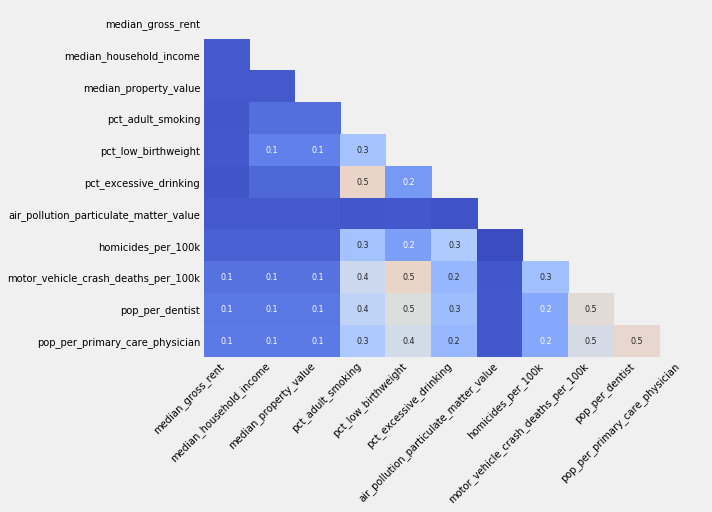

In [10]:
import missingno as msno
msno.heatmap(all_data, cmap='coolwarm', figsize=(8,6), fontsize=10);

The heatmap mostly shows no nullity correlation between missing values, meaning that the presence or absence of variables have no effect on one another. The 0.5 correlations shows variables that usually coexist, perhaps indicating features that were produced from the same survey. 

All missing data are numerical features and there are no obvious signs of MNAR/structrually missing data. Therefore, I'll deal with missing data by imputation or dropping columns where >60% of entries are missing ('homicides_per_100k'). 

First treat the missing features unique to the train & test sets

In [11]:
same = missing_train_df.index.tolist() == missing_test_df.index.tolist()
print("Training & Test data have missing data in the same features: {}".format(same))
if same==False:
    mismatch = set(missing_train_df.index.tolist()) ^ set(missing_test_df.index.tolist()) # Symmetric difference
    print("Mismatched missing features: {}".format(mismatch))

Training & Test data have missing data in the same features: False
Mismatched missing features: {'median_property_value', 'median_household_income', 'median_gross_rent'}


In [12]:
# Fill unique missing features using the median training set value
train_data.loc[train_data['median_property_value'].isnull(),'median_property_value'] = train_data['median_property_value'].median()
train_data.loc[train_data['median_household_income'].isnull(),'median_household_income'] = train_data['median_household_income'].median()
test_data.loc[test_data['median_gross_rent'].isnull(),'median_gross_rent'] = train_data['median_gross_rent'].median()

# Drop column with >60% missing data
train_data.drop(columns='homicides_per_100k', inplace=True)
test_data.drop(columns='homicides_per_100k', inplace=True)

In [13]:
missing_train_df = train_data.isnull().sum()
missing_train_df = pd.DataFrame(missing_train_df[missing_train_df>0].sort_values(ascending=False), columns=['Total'])
missing_train_df['%'] = np.round((missing_train_df['Total']/len(train_data))*100, decimals=2)
print("Missing features in Train data")
missing_train_df

Missing features in Train data


Total      %
pct_excessive_drinking                    810  31.81
pct_adult_smoking                         408  16.03
motor_vehicle_crash_deaths_per_100k       308  12.10
pop_per_dentist                           190   7.46
pop_per_primary_care_physician            175   6.87
pct_low_birthweight                       126   4.95
air_pollution_particulate_matter_value      1   0.04

In [14]:
missing_test_df = test_data.isnull().sum()
missing_test_df = pd.DataFrame(missing_test_df[missing_test_df>0].sort_values(ascending=False), columns=['Total'])
missing_test_df['%'] = np.round((missing_test_df['Total']/len(test_data))*100, decimals=2)
print("Missing features in Test data")
missing_test_df

Missing features in Test data


Total      %
pct_excessive_drinking                    718  29.67
pct_adult_smoking                         344  14.21
motor_vehicle_crash_deaths_per_100k       272  11.24
pop_per_dentist                           163   6.74
pop_per_primary_care_physician            143   5.91
pct_low_birthweight                       107   4.42
air_pollution_particulate_matter_value      3   0.12

In [15]:
same = missing_train_df.index.tolist() == missing_test_df.index.tolist()
print("Training & Test data have missing data in the same features: {}".format(same))
if same==False:
    mismatch = set(missing_train_df.index.tolist()) ^ set(missing_test_df.index.tolist()) # Symmetric difference
    print("Mismatched missing features: {}".format(mismatch))

Training & Test data have missing data in the same features: True


<br>
<br>

In [16]:
from fancyimpute import IterativeImputer
from sklearn.impute import SimpleImputer

class MissingData(BaseEstimator, TransformerMixin):
    """
    Custom transformer following scikit-learn's transformer API. Used to 
    deal with NUMERICAL missing data for the eviction dataset.
    Accepts Pandas DataFrames not data arrays.
    
    Parameters
    ----------
    impute_method: string
        Toggle between imputation methods. Use one of either
        'median' to impute using the median value or 'iterative' to use 
        fancyimpute's IterativeImputer object (based off of MICE).
    """
    def __init__(self, impute_method='median'):
        
        if impute_method not in {'median', 'iterative'}:
            raise ValueError('Invalid impute_method "%s"' % impute_method)
        
        if impute_method=='median':
            self.imputer = SimpleImputer(strategy='median')
        else:
            self.imputer = IterativeImputer(sample_posterior=True, n_iter=100)
        self.impute_method = impute_method
    
    def fit(self, X, y=None):
        """
        Use only numerical features (and non-identifiers) from the training set to 
        fit missing features. The dataset that is transformed must have the same
        columns as the dataset that the imputer was fitted on.
        """
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(exclude=['int64', 'object'])
        self.missing_feats = X_copy.columns.tolist()
        X_copy_values = X_copy.values
        self.imputer.fit(X_copy_values)
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        missing = X_copy[self.missing_feats]
        X_copy.drop(columns=self.missing_feats, inplace=True)
        missing = self.imputer.transform(missing)
        missing_df = pd.DataFrame(data=missing, columns=self.missing_feats)
        X_copy = X_copy.merge(missing_df, left_index=True, right_index=True)
        return X_copy

C:\Users\WongT\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
missing_imp = MissingData(impute_method='median')

a = missing_imp.fit_transform(train_data)
b = missing_imp.transform(test_data)

In [18]:
missing_imp = MissingData(impute_method='iterative')

c = missing_imp.fit_transform(train_data)
d = missing_imp.transform(test_data)

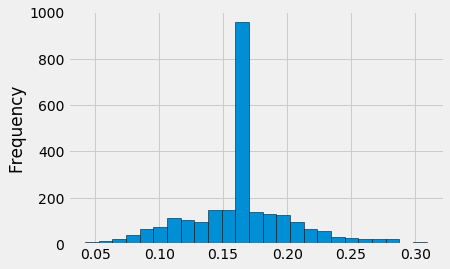

In [19]:
a['pct_excessive_drinking'].plot.hist(bins=25, edgecolor='k')

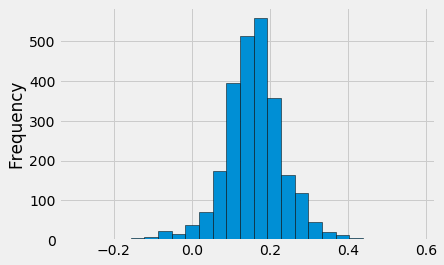

In [20]:
c['pct_excessive_drinking'].plot.hist(bins=25, edgecolor='k')

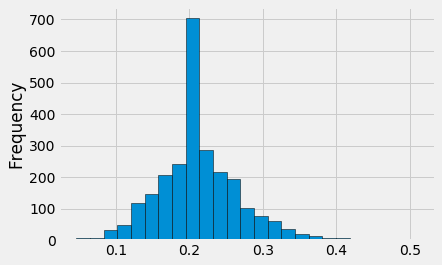

In [21]:
a['pct_adult_smoking'].plot.hist(bins=25, edgecolor='k')

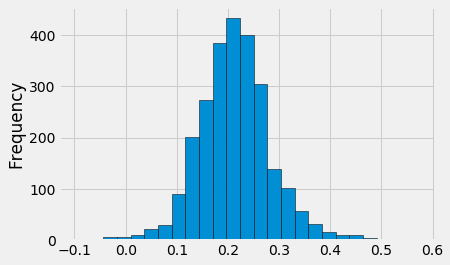

In [22]:
c['pct_adult_smoking'].plot.hist(bins=25, edgecolor='k')

I'll use IterativeImputer as its imputation procedure generates more normally distributed and less peaky features

In [23]:
missing_imp = MissingData(impute_method='iterative')

train_data = missing_imp.fit_transform(train_data)
test_data = missing_imp.transform(test_data)

Clip values of imputed features that are <0.

In [24]:
imp_feats = missing_train_df.index.tolist()

train_data[imp_feats] = train_data[imp_feats].apply(lambda x: np.clip(x, 0, None))
test_data[imp_feats] = test_data[imp_feats].apply(lambda x: np.clip(x, 0, None))

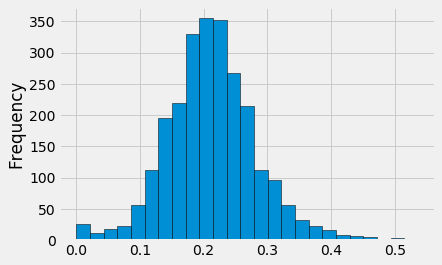

In [25]:
train_data['pct_adult_smoking'].plot.hist(bins=25, edgecolor='k')

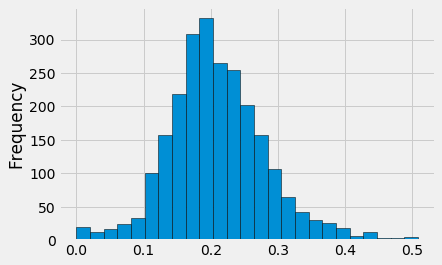

In [26]:
test_data['pct_adult_smoking'].plot.hist(bins=25, edgecolor='k')

Any more missing values?

In [27]:
missing_train_df = train_data.isnull().sum()
missing_train_df = pd.DataFrame(missing_train_df[missing_train_df>0].sort_values(ascending=False), columns=['Total'])
missing_train_df['%'] = np.round((missing_train_df['Total']/len(train_data))*100, decimals=2)
print("Missing features in Train data")
missing_train_df

Missing features in Train data


Empty DataFrame
Columns: [Total, %]
Index: []

In [28]:
missing_test_df = test_data.isnull().sum()
missing_test_df = pd.DataFrame(missing_test_df[missing_test_df>0].sort_values(ascending=False), columns=['Total'])
missing_test_df['%'] = np.round((missing_test_df['Total']/len(test_data))*100, decimals=2)
print("Missing features in Test data")
missing_test_df

Missing features in Test data


Empty DataFrame
Columns: [Total, %]
Index: []

<br>
<br>

## Transform categorical features

In [29]:
train_data.select_dtypes(include=['int64','object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Data columns (total 8 columns):
row_id                              2546 non-null int64
county_code                         2546 non-null object
year                                2546 non-null object
state                               2546 non-null object
rucc                                2546 non-null object
urban_influence                     2546 non-null object
economic_typology                   2546 non-null object
heart_disease_mortality_per_100k    2546 non-null int64
dtypes: int64(2), object(6)
memory usage: 159.2+ KB


In [30]:
train_data['rucc'].value_counts()

Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area                         466
Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area    370
Metro - Counties in metro areas of 1 million population or more                                  358
Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area                     337
Metro - Counties in metro areas of 250,000 to 1 million population                               289
Metro - Counties in metro areas of fewer than 250,000 population                                 261
Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area        210
Nonmetro - Urban population of 20,000 or more, adjacent to a metro area                          170
Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area                       85
Name: rucc, dtype: int64

In [31]:
train_data['urban_influence'].value_counts()

Small-in a metro area with fewer than 1 million residents                                             550
Large-in a metro area with at least 1 million residents or more                                       358
Noncore adjacent to a small metro with town of at least 2,500 residents                               270
Micropolitan adjacent to a small metro area                                                           201
Micropolitan not adjacent to a metro area                                                             197
Noncore adjacent to micro area and contains a town of 2,500-19,999 residents                          174
Noncore not adjacent to a metro/micro area and does not contain a town of at least 2,500 residents    162
Noncore adjacent to micro area and does not contain a town of at least 2,500 residents                158
Noncore adjacent to a small metro and does not contain a town of at least 2,500 residents             146
Noncore adjacent to a large metro area        

In [32]:
train_data['economic_typology'].value_counts()

Nonspecialized                        1024
Manufacturing-dependent                410
Farm-dependent                         360
Federal/State government-dependent     290
Recreation                             248
Mining-dependent                       214
Name: economic_typology, dtype: int64

Drop ID columns (row_id, county code, year, state) and produce dummy variables for the rest of the nominal categorical variables during modelling stage.

In [33]:
train_row_id = train_data['row_id']
test_row_id = test_data['row_id']
train_data.drop(columns=['row_id', 'county_code', 'year', 'state'], inplace=True)
test_data.drop(columns=['row_id', 'county_code', 'year', 'state'], inplace=True)

In [34]:
# Keep seperate for EDA
#train_data_ohe = pd.get_dummies(train_data, drop_first=True).astype('float64')
#test_data_ohe = pd.get_dummies(test_data, drop_first=True).astype('float64')

<br>
<br>

# Exploratory Data Analysis

<br>
<br>

## Feature/Target transformations

<br>
<br>

### Target variable

In [35]:
train_labels['evictions'].describe()

count     2546.000000
mean       378.048311
std       1405.276610
min          0.000000
25%          4.000000
50%         29.000000
75%        160.750000
max      29251.000000
Name: evictions, dtype: float64

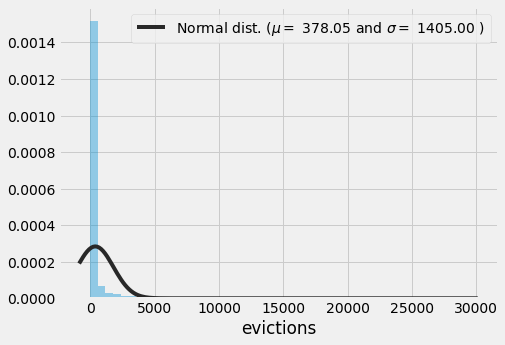

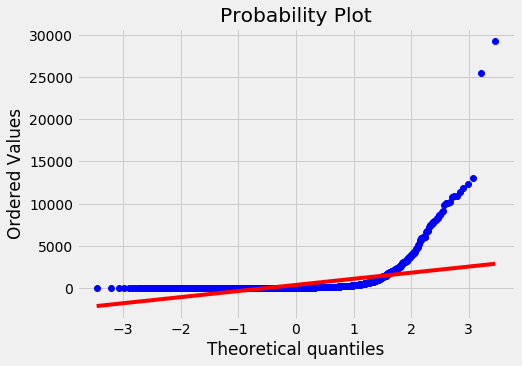

In [36]:
plt.figure(figsize=(7,5))
(mu,sigma) = norm.fit(train_labels['evictions'])
sns.distplot(train_labels['evictions'], fit=norm, kde=False)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.figure(figsize=(7,5))
probplot(train_labels['evictions'], plot=plt)
plt.show()

log(1+x)

In [37]:
train_labels['log_evictions'] = train_labels['evictions'].apply(lambda x: np.log1p(x))

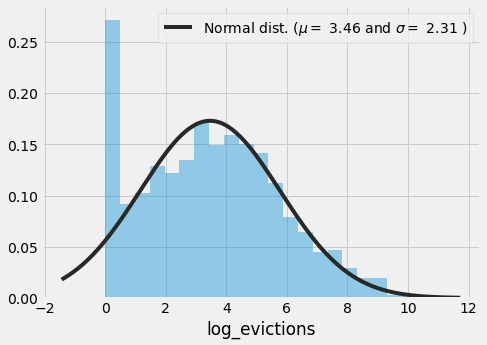

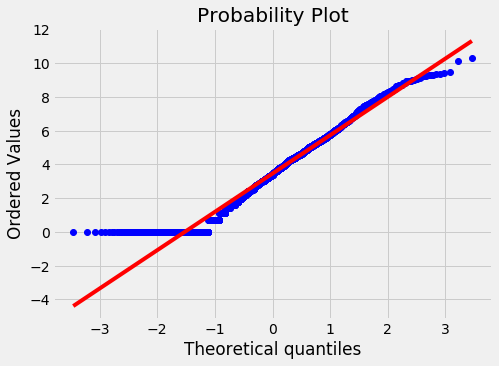

In [38]:
plt.figure(figsize=(7,5))
(mu,sigma) = norm.fit(train_labels['log_evictions'])
sns.distplot(train_labels['log_evictions'], fit=norm, kde=False)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.figure(figsize=(7,5))
probplot(train_labels['log_evictions'], plot=plt)
plt.show()

boxcox

In [39]:
from scipy.stats import boxcox

In [40]:
boxcox_evictions, _ = boxcox(train_labels['evictions']+1)
train_labels['boxcox_evictions'] = boxcox_evictions

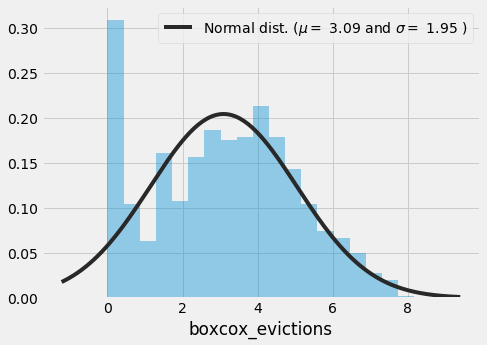

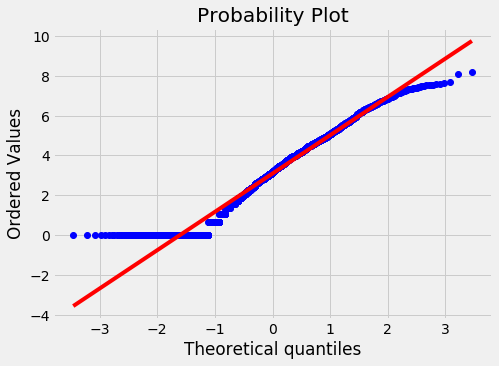

In [41]:
plt.figure(figsize=(7,5))
(mu,sigma) = norm.fit(train_labels['boxcox_evictions'])
sns.distplot(train_labels['boxcox_evictions'], fit=norm, kde=False)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.figure(figsize=(7,5))
probplot(train_labels['boxcox_evictions'], plot=plt)
plt.show()

Use log_evictions as target

<br>
<br>

### Skewed features

In [42]:
numerical_feats = train_data.select_dtypes(exclude=['object']).columns.tolist()

In [43]:
pos_skewed_feats = train_data[numerical_feats].apply(lambda x: skew(x))
pos_skewed_feats = pos_skewed_feats[pos_skewed_feats > 0.75]
pos_skewed_feats = pos_skewed_feats.index

neg_skewed_feats = train_data[numerical_feats].apply(lambda x: skew(x))
neg_skewed_feats = neg_skewed_feats[neg_skewed_feats < -0.75]
neg_skewed_feats = neg_skewed_feats.index

In [44]:
pos_skewed_feats

Index(['population', 'renter_occupied_households', 'pct_renter_occupied',
       'median_gross_rent', 'median_household_income', 'median_property_value',
       'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian', 'pct_nh_pi',
       'pct_multiple', 'pct_other', 'poverty_rate', 'pct_unemployment',
       'pct_uninsured_children', 'pct_low_birthweight',
       'motor_vehicle_crash_deaths_per_100k', 'pop_per_dentist',
       'pop_per_primary_care_physician',
       'pct_adults_less_than_a_high_school_diploma',
       'pct_adults_bachelors_or_higher', 'birth_rate_per_1k'],
      dtype='object')

In [45]:
neg_skewed_feats

Index(['pct_white', 'pct_female'], dtype='object')

Transform positve skewed features using log(1+x) transformation

In [46]:
train_data_tranf = train_data.copy()

# log(1+x)
pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

# (box_cox)
#pos_skewed_feat_names = ['boxcox_'+str(col) for col in pos_skewed_feats]
#train_data_tranf[pos_skewed_feat_names] = train_data_tranf[pos_skewed_feats].apply(lambda x: boxcox(x+1)[0])

Check transformation for 'population'

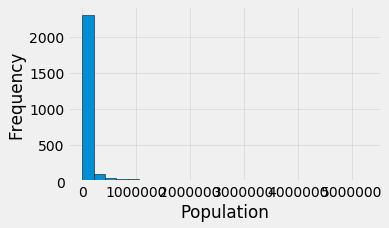

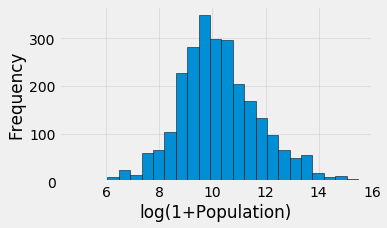

In [47]:
plt.figure(figsize=(5,3))
train_data['population'].plot.hist(bins=25, edgecolor='k')
plt.xlabel("Population");
plt.grid(True, alpha=0.5)

plt.figure(figsize=(5,3))
train_data_tranf['log_population'].plot.hist(bins=25, edgecolor='k')
plt.grid(True, alpha=0.5)
plt.xlabel("log(1+Population)");

<br>
<br>

### Multicollinearity

In [48]:
corr = train_data_tranf.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.80)]
to_drop

['log_renter_occupied_households', 'log_median_property_value']

In [49]:
corr['log_renter_occupied_households'].sort_values(ascending=False)

log_renter_occupied_households                    1.000000
log_population                                    0.989159
log_median_gross_rent                             0.610876
log_pct_asian                                     0.539528
log_median_property_value                         0.521677
log_pct_adults_bachelors_or_higher                0.493819
log_pct_renter_occupied                           0.474464
rent_burden                                       0.389629
log_median_household_income                       0.334981
pct_female                                        0.286132
log_pct_other                                     0.280479
log_birth_rate_per_1k                             0.256418
log_pct_af_am                                     0.192680
log_pct_multiple                                  0.164847
pct_below_18_years_of_age                         0.124326
log_pct_nh_pi                                     0.098871
log_pct_unemployment                              0.0681

In [50]:
corr['log_median_property_value'].sort_values(ascending=False)

log_median_property_value                         1.000000
log_median_gross_rent                             0.809780
log_pct_adults_bachelors_or_higher                0.747298
log_median_household_income                       0.700923
log_population                                    0.525054
log_renter_occupied_households                    0.521677
log_pct_asian                                     0.519530
pct_civilian_labor                                0.327569
log_pct_other                                     0.311225
rent_burden                                       0.189323
pct_excessive_drinking                            0.174164
log_pct_renter_occupied                           0.163830
log_pct_nh_pi                                     0.155574
pct_adults_with_some_college                      0.124938
log_pct_multiple                                  0.121562
pct_female                                        0.115568
pct_white                                         0.0615

- 'renter_occupied_households' is highly correlated (0.99) with 'population'
- 'median_property_value' is highly correlated (0.81) with 'median_gross_rent'

In [51]:
train_data_copy = train_data_tranf.copy()
train_data_copy['evictions'] = train_labels['evictions']
train_data_copy['log_evictions'] = train_labels['log_evictions']

In [52]:
pd.DataFrame({'log_renter_occupied_households':train_data_copy['log_renter_occupied_households'].values,
              'log_population':train_data_copy['log_population'].values, 
              'log_median_property_value':train_data_copy['log_median_property_value'].values,
              'log_median_gross_rent':train_data_copy['log_median_gross_rent'].values,
              'log_evictions':train_data_copy['log_evictions'].values}).corr()

log_renter_occupied_households  \
log_renter_occupied_households                        1.000000   
log_population                                        0.989159   
log_median_property_value                             0.521677   
log_median_gross_rent                                 0.610876   
log_evictions                                         0.886482   

                                log_population  log_median_property_value  \
log_renter_occupied_households        0.989159                   0.521677   
log_population                        1.000000                   0.525054   
log_median_property_value             0.525054                   1.000000   
log_median_gross_rent                 0.615946                   0.809780   
log_evictions                         0.879176                   0.447003   

                                log_median_gross_rent  log_evictions  
log_renter_occupied_households               0.610876       0.886482  
log_population                               0.615946       0.879176  
log_median_property_value                    0.809780       0.447003  
log_median_gross_rent                        1.000000       0.540738  
log_evictions                                0.540738       1.000000

In [53]:
del(train_data_copy)

I'll be conservative at this stage and thus will not prune the multicollinear features right now. Instead I'll allow the feature selection packages used during the modelling stage to prune features if doing so will result in a better model.

<br>
<br>

### Correlations

In [54]:
train_data_copy = train_data_tranf.copy()
train_data_copy['evictions'] = train_labels['evictions']
train_data_copy['log_evictions'] = train_labels['log_evictions']

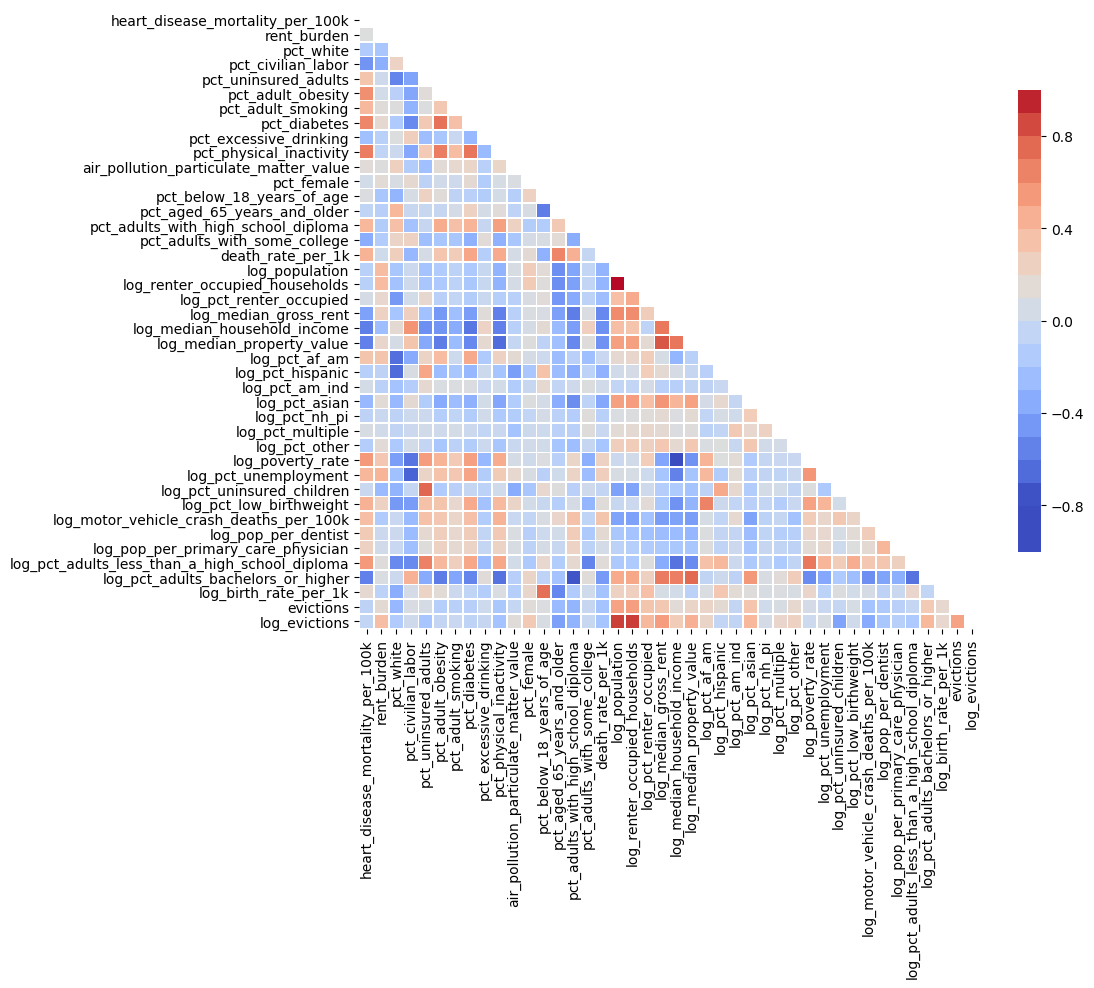

In [55]:
plt.style.use('default')

mask = np.zeros_like(train_data_copy.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8));
sns.heatmap(train_data_copy.corr(), linewidths=0.5, cmap='coolwarm', mask=mask,
            cbar_kws={'boundaries':np.linspace(-1,1, 21).tolist(), 'shrink':0.75});

In [56]:
train_data_copy = train_data.copy()
train_data_copy['evictions'] = train_labels['evictions']
train_data_copy['log_evictions'] = train_labels['log_evictions']

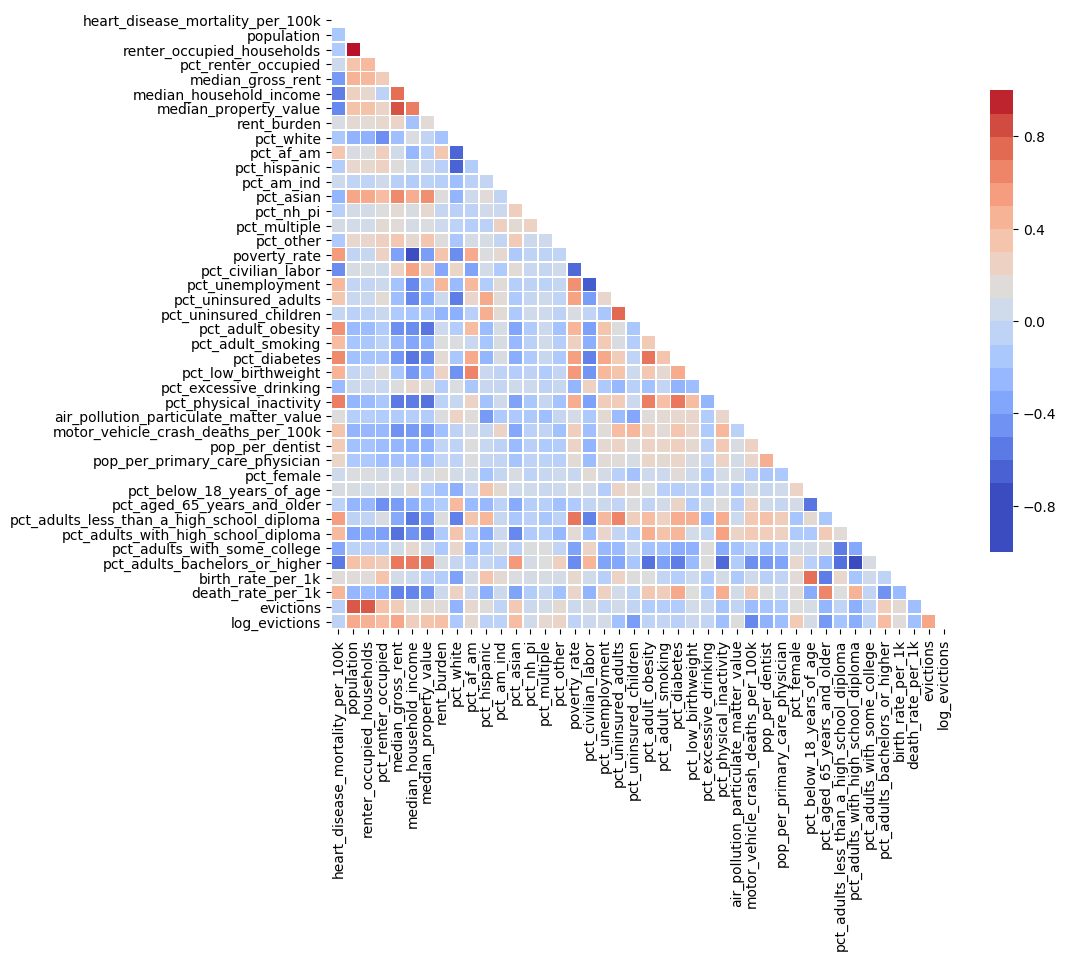

In [57]:
plt.style.use('default')

mask = np.zeros_like(train_data_copy.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8));
sns.heatmap(train_data_copy.corr(), linewidths=0.5, cmap='coolwarm', mask=mask,
            cbar_kws={'boundaries':np.linspace(-1,1, 21).tolist(), 'shrink':0.75});

In [58]:
del(train_data_copy)

<br>
<br>

### Pairplot

In [59]:
train_data_copy = train_data_tranf.copy()
train_data_copy['evictions'] = train_labels['evictions']
train_data_copy['log_evictions'] = train_labels['log_evictions']

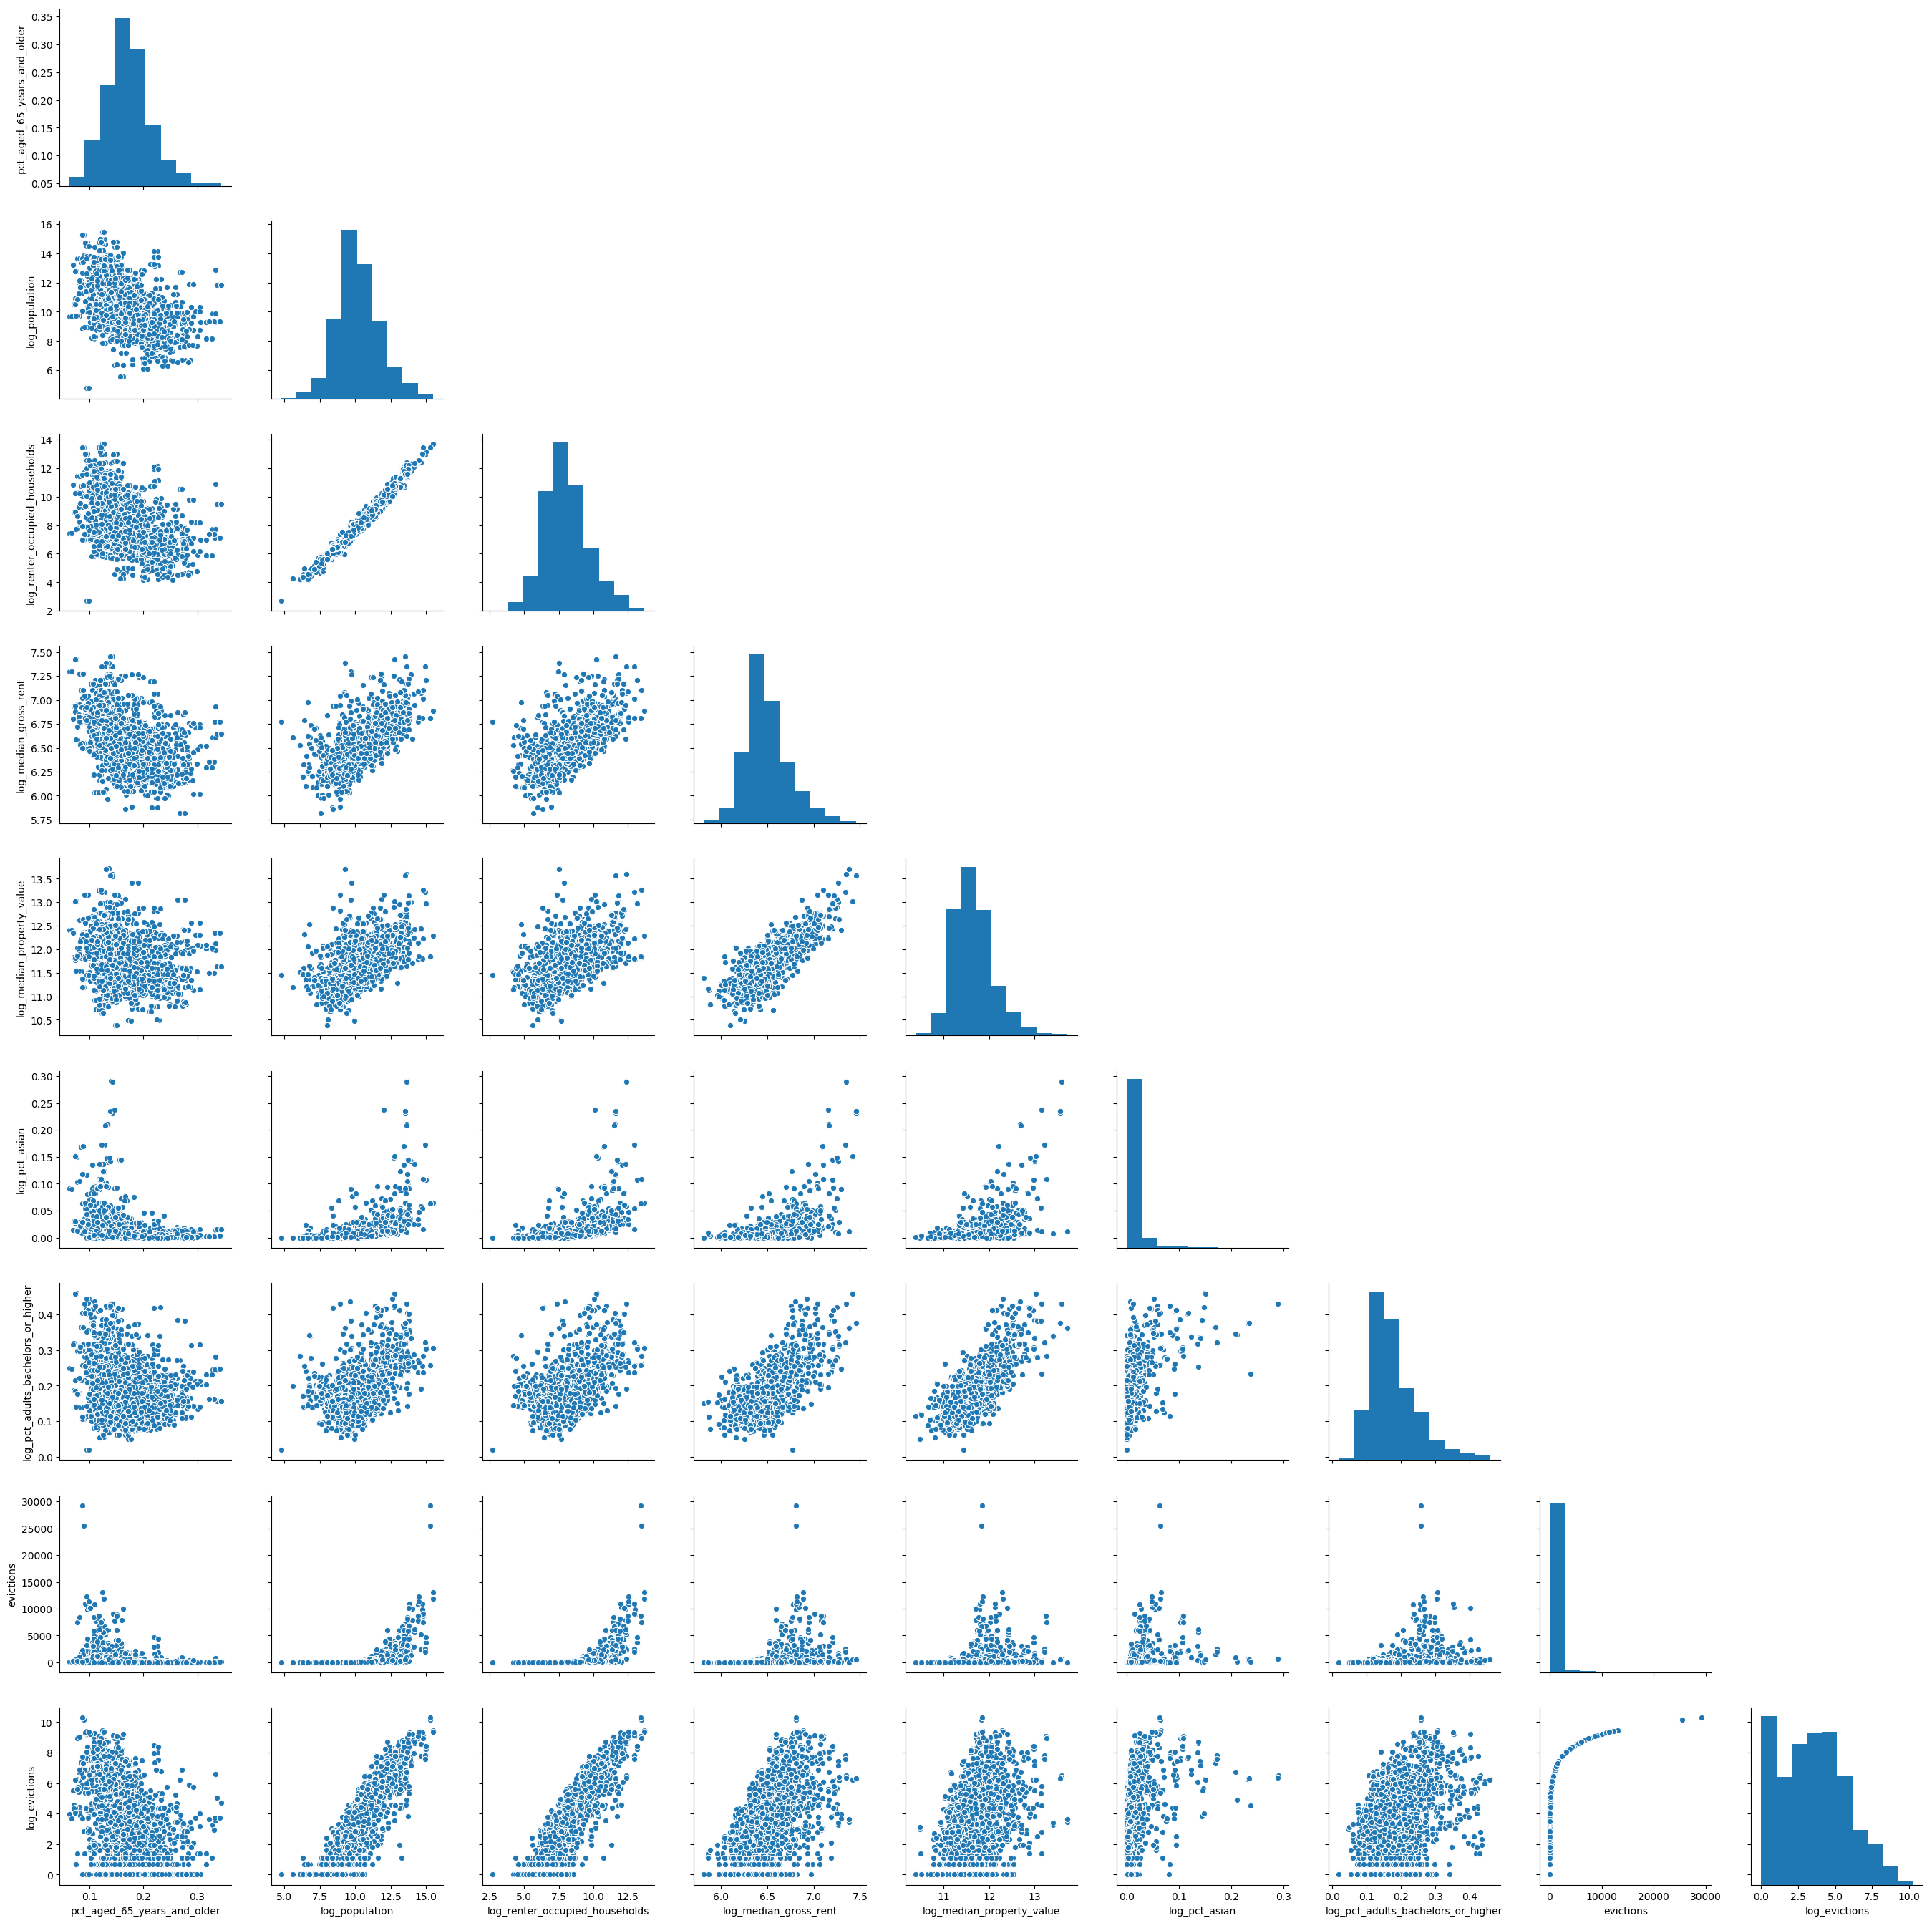

In [60]:
corr = np.abs(train_data_copy.corr()['log_evictions'])
feats = corr[corr>0.4].index

g = sns.pairplot(train_data_copy.loc[:,feats], height=3)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

In [61]:
del(train_data_copy)

<br>
<br>

## Outliers

In [62]:
train_labels['evictions'].describe()

count     2546.000000
mean       378.048311
std       1405.276610
min          0.000000
25%          4.000000
50%         29.000000
75%        160.750000
max      29251.000000
Name: evictions, dtype: float64

In [63]:
train_labels['evictions'].quantile(0.975)

3570.75

In [64]:
#outlier_idx = train_labels.loc[train_labels['evictions']>15000, 'evictions'].index
#train_data.drop(index=outlier_idx, inplace=True)
#train_labels.drop(index=outlier_idx, inplace=True)

# 3 - 24/01/2019 (97.5%)
#outlier_idx = train_labels.loc[train_labels['evictions']>3571, 'evictions'].index
#train_data.drop(index=outlier_idx, inplace=True)
#train_labels.drop(index=outlier_idx, inplace=True)

# 3 - 24/01/2019 (95%)
#outlier_idx = train_labels.loc[train_labels['evictions']>1877, 'evictions'].index
#train_data.drop(index=outlier_idx, inplace=True)
#train_labels.drop(index=outlier_idx, inplace=True)

<br>
<br>

## Most "important" features

In [63]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [64]:
from sklearn.preprocessing import StandardScaler

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

y_train = train_labels['evictions'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [65]:
feat_imp_forest = RandomForestRegressor(n_estimators=200, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=4,)
                                    #max_features='sqrt')

sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>500)] += 10

feat_imp_forest.fit(X_train, y_train, sample_weights)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [66]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) log_renter_occupied_households 0.415352
 2) log_population                 0.269049
 3) log_poverty_rate               0.054496
 4) log_pct_af_am                  0.051901
 5) log_median_property_value      0.029198
 6) heart_disease_mortality_per_100k 0.016985
 7) rent_burden                    0.011020
 8) log_pct_low_birthweight        0.010629
 9) pct_physical_inactivity        0.010492
10) log_pct_am_ind                 0.009673
11) log_pct_multiple               0.008648
12) pct_civilian_labor             0.008068
13) log_pct_renter_occupied        0.006764
14) log_pct_other                  0.006286
15) pct_below_18_years_of_age      0.006139
16) pct_adults_with_high_school_diploma 0.005478
17) log_motor_vehicle_crash_deaths_per_100k 0.005253
18) log_median_gross_rent          0.004466
19) log_pct_nh_pi                  0.004402
20) pct_adult_obesity              0.004169
21) log_median_household_income    0.004148
22) log_pop_per_dentist            0.004104
23) log_pct_asia

Make a DataFrame of feature importances

In [67]:
feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()
feat_import_df

Feature name  Feature importance  \
0                      log_renter_occupied_households        4.153515e-01   
1                                      log_population        2.690486e-01   
2                                    log_poverty_rate        5.449643e-02   
3                                       log_pct_af_am        5.190093e-02   
4                           log_median_property_value        2.919796e-02   
5                    heart_disease_mortality_per_100k        1.698471e-02   
6                                         rent_burden        1.102048e-02   
7                             log_pct_low_birthweight        1.062918e-02   
8                             pct_physical_inactivity        1.049187e-02   
9                                      log_pct_am_ind        9.672609e-03   
10                                   log_pct_multiple        8.648004e-03   
11                                 pct_civilian_labor        8.067911e-03   
12                            log_pct_renter_occupied        6.764482e-03   
13                                      log_pct_other        6.285931e-03   
14                          pct_below_18_years_of_age        6.139046e-03   
15                pct_adults_with_high_school_diploma        5.477886e-03   
16            log_motor_vehicle_crash_deaths_per_100k        5.252774e-03   
17                              log_median_gross_rent        4.465969e-03   
18                                      log_pct_nh_pi        4.402381e-03   
19                                  pct_adult_obesity        4.168992e-03   
20                        log_median_household_income        4.148016e-03   
21                                log_pop_per_dentist        4.104439e-03   
22                                      log_pct_asian        4.009382e-03   
23                       pct_adults_with_some_college        3.808946e-03   
24                                   log_pct_hispanic        3.706344e-03   
25                                       pct_diabetes        3.336889e-03   
26                                          pct_white        3.158799e-03   
27                               pct_uninsured_adults        3.130971e-03   
28                               log_pct_unemployment        3.041148e-03   
29             air_pollution_particulate_matter_value        2.964369e-03   
..                                                ...                 ...   
34                             pct_excessive_drinking        2.458807e-03   
35                              log_birth_rate_per_1k        2.447607e-03   
36                                         pct_female        2.194971e-03   
37                                  death_rate_per_1k        2.187333e-03   
38                 log_pop_per_primary_care_physician        2.120859e-03   
39                         log_pct_uninsured_children        1.705094e-03   
40                 economic_typology_Mining-dependent        9.310138e-04   
41                   economic_typology_Nonspecialized        3.531251e-04   
42  urban_influence_Small-in a metro area with few...        2.008455e-04   
43  economic_typology_Federal/State government-dep...        1.562267e-04   
44                       economic_typology_Recreation        1.044658e-04   
45  rucc_Metro - Counties in metro areas of 250,00...        8.542477e-05   
46          economic_typology_Manufacturing-dependent        3.745002e-05   
47  rucc_Metro - Counties in metro areas of fewer ...        1.955404e-05   
48  rucc_Nonmetro - Urban population of 20,000 or ...        4.859872e-06   
49  urban_influence_Micropolitan adjacent to a lar...        2.656142e-06   
50  urban_influence_Micropolitan adjacent to a sma...        3.073789e-07   
51  rucc_Nonmetro - Urban population of 20,000 or ...        1.283443e-07   
52  urban_influence_Micropolitan not adjacent to a...        4.257325e-08   
53  rucc_Nonmetro - Urban population of 2,500 to 1...        4.243545e-08   
54  urban_influence_Noncore not adjac

Plot the 15 most important features

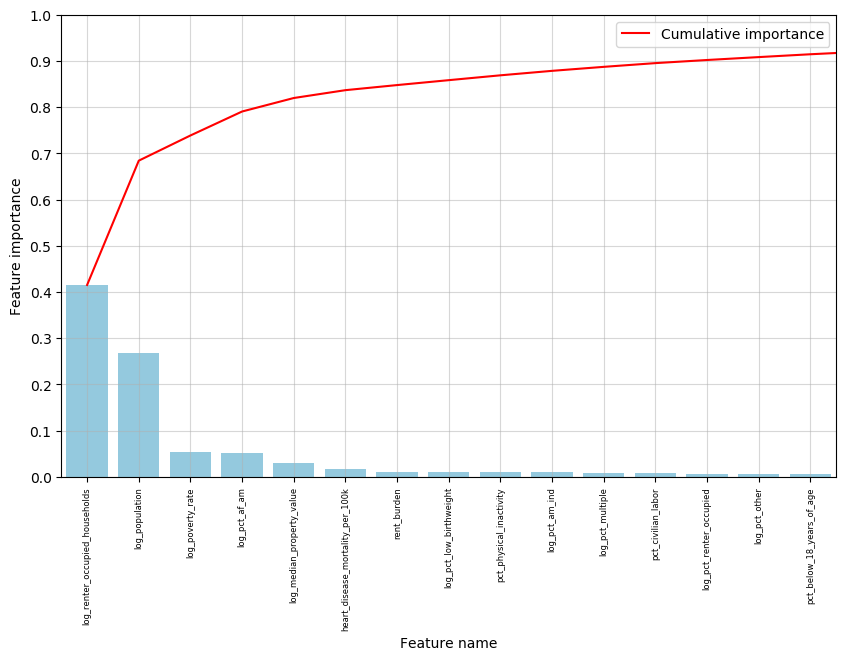

In [68]:
plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

<br>
<br>

# Machine Learning models

<br>
<br>

## SVR (RBF Kernel)

In [63]:
outlier_idx = train_labels.loc[train_labels['evictions']>15000, 'evictions'].index
train_data.drop(index=outlier_idx, inplace=True)
train_labels.drop(index=outlier_idx, inplace=True)

train_data_tranf = train_data.copy()

# log(1+x)
pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

In [64]:
from sklearn.preprocessing import StandardScaler
import time

In [65]:
X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

y_train = train_labels['evictions'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

<br>
<br>

**Grid Search**

In [95]:
import time
svr = SVR(kernel='rbf')
kfold_by_states = GroupKFold(10)

# Coarse search
#param_grid = [{'gamma':['scale'],
#               'C':[1e5, 3e5, 1e6, 3e6],
#               'epsilon':[0.01, 0.03, 0.1, 0.3]}]
# Best params: C=1e5, epsilon=1e-2, r2=0.8648610881631027

# Fine search
param_grid = [{'gamma':['scale'],
               'C':[1e5, 1.5e5, 2e5],
               'epsilon':[0.0001, 0.0003, 0.001]}]
# Best params: C=1e5, epsilon=1e-4, r2=0.8648613177308324

gs = GridSearchCV(estimator=svr, 
                  param_grid=param_grid, 
                  scoring='r2', 
                  n_jobs=4, 
                  iid=False, 
                  #cv=kfold_by_states.split(X_train, y_train, states), 
                  cv=10,
                  return_train_score=True)

start = time.time()
gs.fit(X_train, y_train, states)
end = time.time()

print(end - start, "seconds elapsed")
print(gs.best_params_)
print(gs.best_score_)

175.490980386734 seconds elapsed
{'C': 100000.0, 'epsilon': 0.0001, 'gamma': 'scale'}
0.8648613177308324


<br>
<br>

In [111]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

svr = SVR(kernel='rbf', gamma='scale', C=1e3, epsilon=1e1, tol=1e2)
# R2: 0.868 +/- 0.088

#svr = SVR(kernel='rbf', gamma='scale', C=1e5, epsilon=1e-2)
# R2: 0.864 +/- 0.088

cvs = cross_val_score(svr, X_train, y_train, scoring='r2', cv=10, n_jobs=4)

print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

R2: 0.716 +/- 0.059


<br>
<br>

**Sample weights**

In [308]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>500)] += 11

<br>
<br>

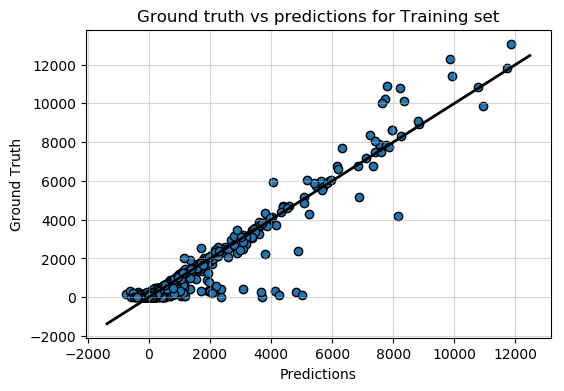

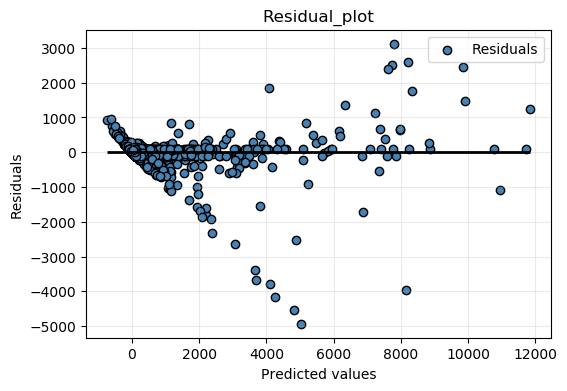

In [309]:
svr = SVR(kernel='rbf', gamma='scale', C=1e3, epsilon=1e2, tol=1e-3)
svr.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_train = svr.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')
plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train - y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='best')
plt.grid(alpha=0.25);
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

<br>
<br>

**Search for overestimated residuals**

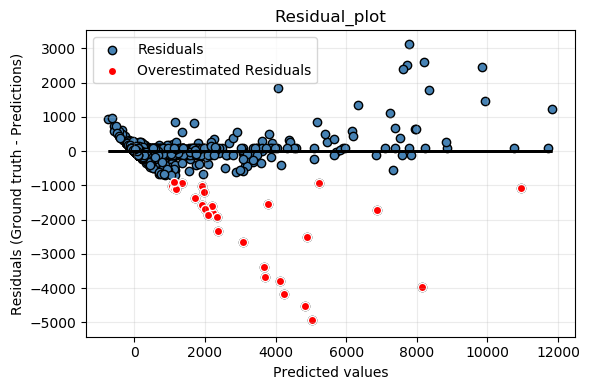

In [123]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

residual = y_train-y_pred_train

plt.scatter(y_pred_train[np.argwhere(residual<-750)], residual[np.argwhere(residual<-750)],
            c='red', marker='o', edgecolor='white',
            label='Overestimated Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [285]:
# 5, 191, 1072, 1203, 1208, 2415
influential_points = np.argwhere(residual<-750)
influential_points = np.delete(influential_points, [0, 2, 13, 14, 15, 27])

In [287]:
influential_points

array([  44,  200,  215,  478,  511,  577,  801,  823,  944, 1023, 1024,
       1212, 1582, 1588, 1844, 1864, 1948, 2031, 2061, 2096, 2163, 2190,
       2417], dtype=int64)

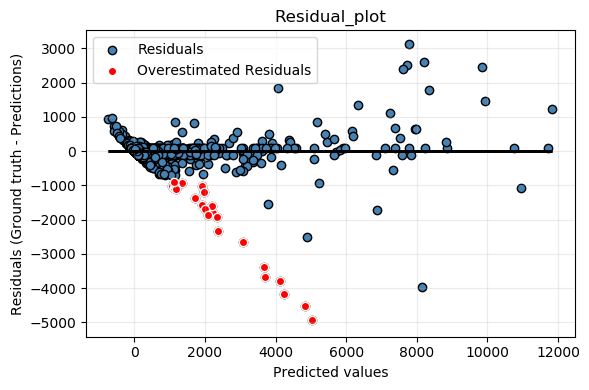

In [286]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

residual = y_train-y_pred_train

plt.scatter(y_pred_train[influential_points], residual[influential_points],
            c='red', marker='o', edgecolor='white',
            label='Overestimated Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

**Boost these points with more sample weights**

In [312]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>500)] += 11
sample_weights[influential_points] +=30

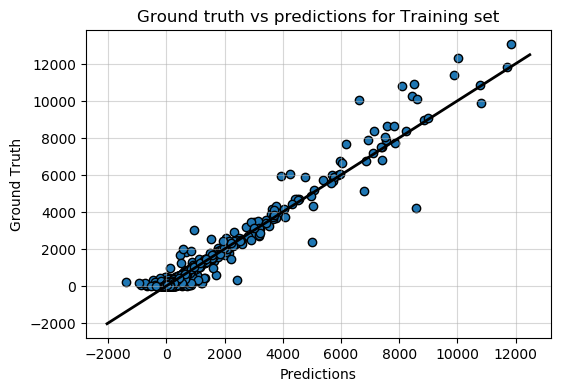

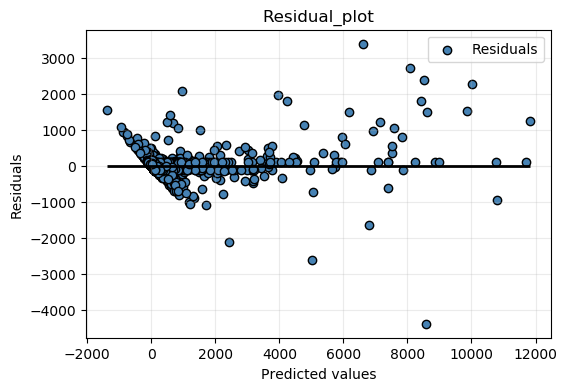

In [313]:
svr = SVR(kernel='rbf', gamma='scale', C=1e3, epsilon=1e2, tol=1e-3)
svr.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_train = svr.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')
plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train - y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='best')
plt.grid(alpha=0.25);
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

<br>
<br>

## XGBoost

In [72]:
outlier_idx = train_labels.loc[train_labels['evictions']>15000, 'evictions'].index
train_data.drop(index=outlier_idx, inplace=True)
train_labels.drop(index=outlier_idx, inplace=True)

train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [73]:
from sklearn.preprocessing import StandardScaler

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

y_train = train_labels['evictions'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [117]:
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit

In [148]:
ss = ShuffleSplit(1, test_size=0.1)

for train_idx, val_idx in ss.split(X_train, y_train):#, states):
    print(train_idx.shape, val_idx.shape)
    X_train_eval, y_train_eval = X_train[train_idx, :], y_train[train_idx]
    X_val_eval, y_val_eval = X_train[val_idx, :], y_train[val_idx]
    

(2289,) (255,)


<br>
<br>

**Sample weights**

Weigh counties with evicitons>4000 more

In [149]:
sample_weights = np.ones_like(y_train_eval)
sample_weights[np.argwhere(y_train_eval>4000)] += 5

<br>
<br>

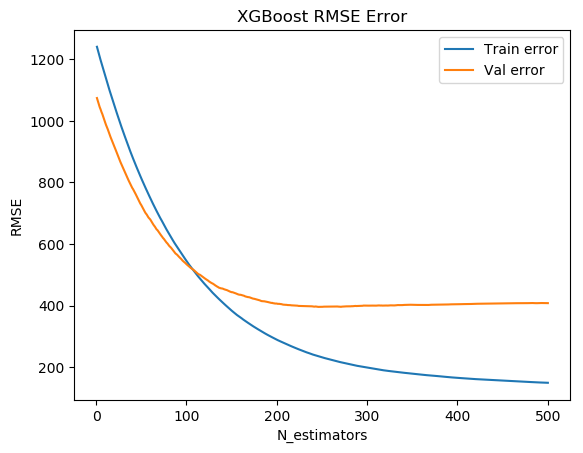

In [151]:
eval_set = [(X_train_eval, y_train_eval), (X_val_eval, y_val_eval)]
eval_metric = ["rmse"]

xgb_regr = XGBRegressor(learning_rate=0.01, 
                        n_estimators=500,
                        max_depth=4,
                        subsample=0.8,
                        reg_lambda=5,
                        n_jobs=4)

xgb_regr.fit(X_train_eval,
             y_train_eval,
             eval_metric=eval_metric,
             eval_set=eval_set,
             verbose=False,
             sample_weight=sample_weights)

results = xgb_regr.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

train_n_estimators = np.array([i for i in range(1, len(train_error)+1)])
val_n_estimators = np.array([i for i in range(1, len(val_error)+1)])

plt.plot(train_n_estimators, train_error, label='Train error')
plt.plot(val_n_estimators, val_error, label='Val error')
plt.legend(loc='best');
plt.xlabel('N_estimators');
plt.ylabel('RMSE');
plt.title('XGBoost RMSE Error');

<br>
<br>

**Sample weights**

Weigh counties with evicitons>4000 more

In [210]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>3750)] += 9

<br>
<br>

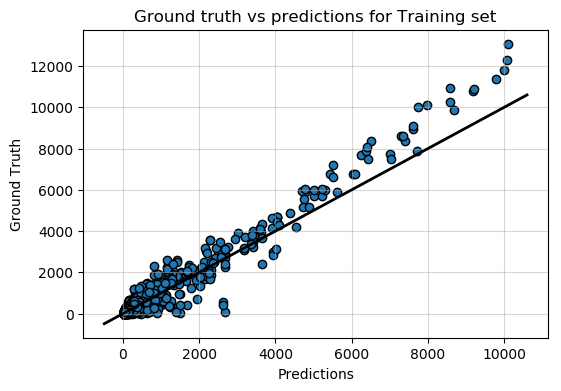

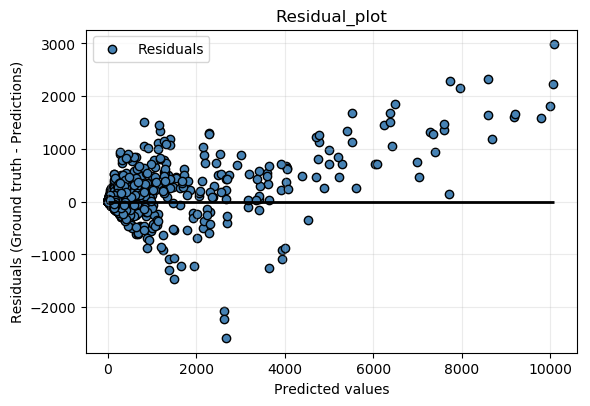

In [211]:
xgb_regr = XGBRegressor(learning_rate=0.01, 
                        n_estimators=200,
                        max_depth=4,
                        #subsample=0.8,
                        #reg_lambda=100,
                        n_jobs=4)

xgb_regr.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_train = xgb_regr.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [ ]:
from sklearn.model_selection import cross_val_score

xgb_regr = XGBRegressor(learning_rate=0.05, 
                        n_estimators=200,
                        max_depth=4,
                        reg_lambda=3,
                        n_jobs=4)
#R2: 0.887 +/- 0.081

#xgb_regr = XGBRegressor(learning_rate=0.05, 
#                        n_estimators=90,
#                        max_depth=4,
#                        subsample=0.8,
#                        reg_lambda=6,
#                       n_jobs=4)
# R2: 0.858 +/- 0.069


cvs = cross_val_score(xgb_regr, X_train, y_train, scoring='r2', cv=10, n_jobs=1)

print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

<br>
<br>

## Random Forest

In [89]:
outlier_idx = train_labels.loc[train_labels['evictions']>15000, 'evictions'].index
train_data.drop(index=outlier_idx, inplace=True)
train_labels.drop(index=outlier_idx, inplace=True)

train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [90]:
from sklearn.preprocessing import StandardScaler

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

y_train = train_labels['evictions'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

In [96]:
ss = ShuffleSplit(1, test_size=0.1)

for train_idx, val_idx in \ss.split(X_train, y_train, states):
    print(train_idx.shape, val_idx.shape)
    X_train_eval, y_train_eval = X_train[train_idx, :], y_train[train_idx]
    X_val_eval, y_val_eval = X_train[val_idx, :], y_train[val_idx]
    
eval_set = [(X_train_eval, y_train_eval), (X_val_eval, y_val_eval)]
eval_metric = ["rmse"]

(2291,) (255,)


<br>
<br>

**Sample weights**

In [290]:
print(train_labels.loc[train_labels['evictions']<500, 'evictions'].count())
print(train_labels.loc[train_labels['evictions']>500, 'evictions'].count())

2235
309


<br>
<br>

In [320]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>500)] += 11

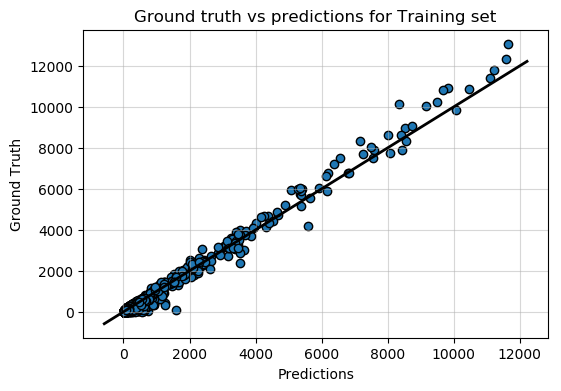

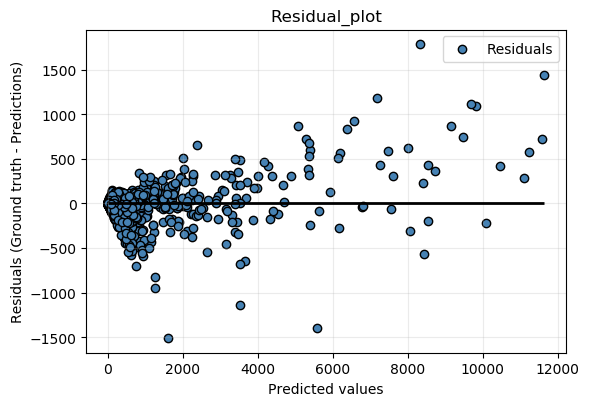

In [321]:
rand_forest = RandomForestRegressor(n_estimators=300, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=4,)
                                    #max_features='sqrt')

rand_forest.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [322]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>500)] += 11
sample_weights[influential_points] += 30

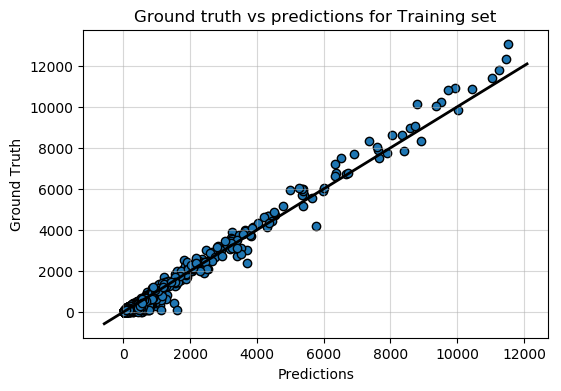

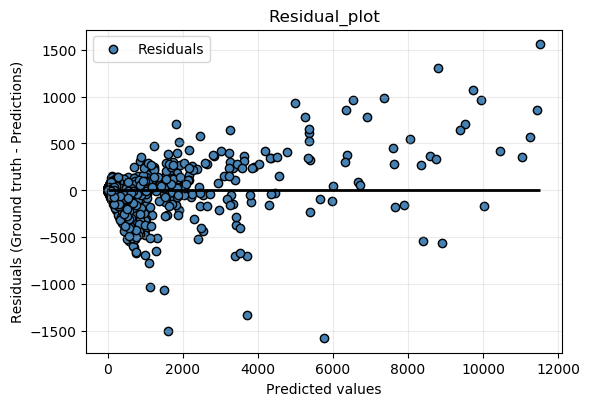

In [323]:
rand_forest = RandomForestRegressor(n_estimators=300, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=4,)
                                    #max_features='sqrt')

rand_forest.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

<br>
<br>

**Search for these overestimated points**

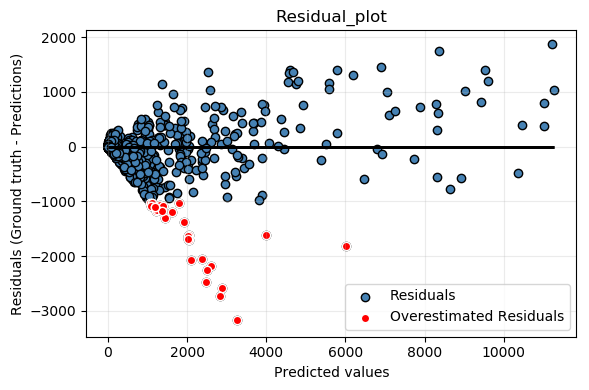

In [117]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

residual = y_train-y_pred_train

plt.scatter(y_pred_train[np.argwhere(residual<-1000)], residual[np.argwhere(residual<-1000)],
            c='red', marker='o', edgecolor='white',
            label='Overestimated Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

<br>
<br>

In [523]:
from sklearn.model_selection import cross_val_score

#rand_forest2 = RandomForestRegressor(n_estimators=200, 
#                                    criterion='mse', 
#                                    max_depth=25, 
#                                    n_jobs=4,
#                                    max_features='sqrt')
# R2: 0.873 +/- 0.052

rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=12, 
                                    n_jobs=2,)
# R2: 0.871 +/- 0.079


cvs = cross_val_score(rand_forest, X_train, y_train, states, scoring='r2', cv=10, n_jobs=2)

print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

R2: 0.871 +/- 0.079


<br>
<br>

## GBDT

In [87]:
from sklearn.ensemble import GradientBoostingRegressor

In [89]:
outlier_idx = train_labels.loc[train_labels['evictions']>15000, 'evictions'].index
train_data.drop(index=outlier_idx, inplace=True)
train_labels.drop(index=outlier_idx, inplace=True)

train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [90]:
from sklearn.preprocessing import StandardScaler

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

y_train = train_labels['evictions'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit
import time

In [96]:
ss = ShuffleSplit(1, test_size=0.1)

for train_idx, val_idx in \ss.split(X_train, y_train, states):
    print(train_idx.shape, val_idx.shape)
    X_train_eval, y_train_eval = X_train[train_idx, :], y_train[train_idx]
    X_val_eval, y_val_eval = X_train[val_idx, :], y_train[val_idx]
    
eval_set = [(X_train_eval, y_train_eval), (X_val_eval, y_val_eval)]
eval_metric = ["rmse"]

(2291,) (255,)


<br>
<br>

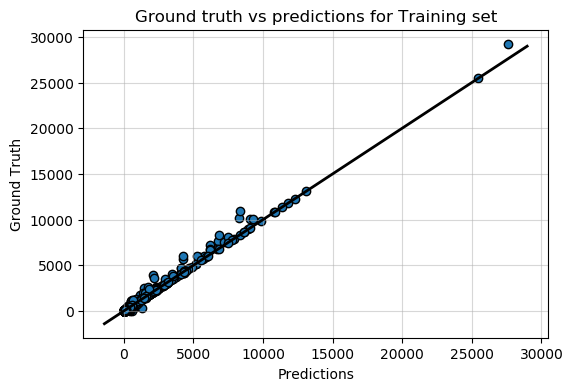

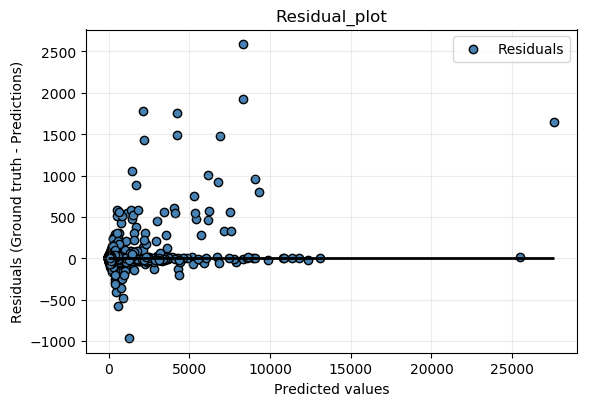

In [532]:
grad_boost_regr = GradientBoostingRegressor(loss='huber', 
                                            learning_rate=0.05, 
                                            n_estimators=300, 
                                            max_depth=5)

grad_boost_regr.fit(X_train, y_train)
y_pred_train = grad_boost_regr.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [533]:
from sklearn.model_selection import cross_val_score

#grad_boost_regr2 = GradientBoostingRegressor(loss='lad', 
#                                            learning_rate=0.05, 
#                                            n_estimators=200, 
#                                            max_depth=15,
#                                            max_features='sqrt')
# R2: 0.893 +/- 0.043

#grad_boost_regr = GradientBoostingRegressor(loss='huber', 
#                                            learning_rate=0.05, 
#                                            n_estimators=400, 
#                                            max_depth=5)
# R2: 0.900 +/- 0.055

grad_boost_regr = GradientBoostingRegressor(loss='huber', 
                                            learning_rate=0.05, 
                                            n_estimators=300, 
                                            max_depth=5)
# R2: 0.885 +/- 0.056


cvs = cross_val_score(grad_boost_regr, X_train, y_train, states, scoring='r2', cv=10, n_jobs=1)

print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

R2: 0.885 +/- 0.056


<br>
<br>

## Averaging

In [72]:
outlier_idx = train_labels.loc[train_labels['evictions']>15000, 'evictions'].index
train_data.drop(index=outlier_idx, inplace=True)
train_labels.drop(index=outlier_idx, inplace=True)

train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [73]:
from sklearn.preprocessing import StandardScaler

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

y_train = train_labels['evictions'].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [74]:
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

svr = SVR(kernel='rbf', gamma='scale', C=1e5, epsilon=1e-2)
# R2: 0.864 +/- 0.088

xgb_regr = XGBRegressor(learning_rate=0.05, 
                        n_estimators=200,
                        max_depth=4,
                        reg_lambda=3,
                        n_jobs=4)
#R2: 0.887 +/- 0.081

rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=12, 
                                    n_jobs=2,)
# R2: 0.871 +/- 0.079

grad_boost_regr = GradientBoostingRegressor(loss='huber', 
                                            learning_rate=0.05, 
                                            n_estimators=300, 
                                            max_depth=5)
# R2: 0.885 +/- 0.056

svr2 = SVR(kernel='rbf', gamma='scale', C=1.2e5, epsilon=1e1, tol=1e2)
# R2: 0.868 +/- 0.088

xgb_regr2 = XGBRegressor(learning_rate=0.05, 
                        n_estimators=90,
                        max_depth=4,
                        subsample=0.8,
                        reg_lambda=6,
                        n_jobs=4)
# R2: 0.858 +/- 0.069

rand_forest2 = RandomForestRegressor(n_estimators=200, 
                                    criterion='mse', 
                                    max_depth=25, 
                                    n_jobs=4,
                                    max_features='sqrt')
# R2: 0.873 +/- 0.052

grad_boost_regr2 = GradientBoostingRegressor(loss='lad', 
                                            learning_rate=0.05, 
                                            n_estimators=200, 
                                            max_depth=15,
                                            max_features='sqrt')
# R2: 0.893 +/- 0.043

In [85]:
ss = ShuffleSplit(1, test_size=0.1)

for train_idx, val_idx in ss.split(X_train, y_train, states):
    print(train_idx.shape, val_idx.shape)
    X_train_eval, y_train_eval = X_train[train_idx, :], y_train[train_idx]
    X_val_eval, y_val_eval = X_train[val_idx, :], y_train[val_idx]


(2291,) (255,)


In [86]:
svr.fit(X_train_eval, y_train_eval)
xgb_regr.fit(X_train_eval, y_train_eval)
rand_forest.fit(X_train_eval, y_train_eval)
grad_boost_regr.fit(X_train_eval, y_train_eval)

svr2.fit(X_train_eval, y_train_eval)
xgb_regr2.fit(X_train_eval, y_train_eval)
rand_forest2.fit(X_train_eval, y_train_eval)
grad_boost_regr2.fit(X_train_eval, y_train_eval)

mean_pred = np.zeros((y_val_eval.shape[0],))

for clf, label in zip([svr, xgb_regr, rand_forest, grad_boost_regr, svr2, xgb_regr2, rand_forest2, grad_boost_regr2], 
                      ['SVR', 'XGBoost', 'Random Forest', 'GBDT', 'SVR2', 'XGBoost2', 'Random Forest2', 'GBDT2']):
    mean_pred += clf.predict(X_val_eval)
    r2_scores = r2_score(y_val_eval, clf.predict(X_val_eval))
    print("R^2 Score: %0.2f [%s]" % (r2_scores, label))

mean_pred = mean_pred / 8
mean_r2 = r2_score(y_val_eval, mean_pred)
print("Mean R^2 Score: %0.2f [%s]" % (mean_r2, 'Average'))

R^2 Score: 0.84 [SVR]
R^2 Score: 0.87 [XGBoost]
R^2 Score: 0.89 [Random Forest]
R^2 Score: 0.88 [GBDT]
R^2 Score: 0.84 [SVR2]
R^2 Score: 0.91 [XGBoost2]
R^2 Score: 0.93 [Random Forest2]
R^2 Score: 0.92 [GBDT2]
Mean R^2 Score: 0.90 [Average]


<br>
<br>

**Get submission**

In [79]:
svr = SVR(kernel='rbf', gamma='scale', C=1e5, epsilon=1e-2)
# R2: 0.864 +/- 0.088

xgb_regr = XGBRegressor(learning_rate=0.05, 
                        n_estimators=200,
                        max_depth=4,
                        reg_lambda=3,
                        n_jobs=4)
#R2: 0.887 +/- 0.081

rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=12, 
                                    n_jobs=2,)
# R2: 0.871 +/- 0.079

grad_boost_regr = GradientBoostingRegressor(loss='huber', 
                                            learning_rate=0.05, 
                                            n_estimators=300, 
                                            max_depth=5)
# R2: 0.885 +/- 0.056

svr2 = SVR(kernel='rbf', gamma='scale', C=1.2e5, epsilon=1e1, tol=1e2)
# R2: 0.868 +/- 0.088

xgb_regr2 = XGBRegressor(learning_rate=0.05, 
                        n_estimators=90,
                        max_depth=4,
                        subsample=0.8,
                        reg_lambda=6,
                        n_jobs=4)
# R2: 0.858 +/- 0.069

rand_forest2 = RandomForestRegressor(n_estimators=200, 
                                    criterion='mse', 
                                    max_depth=25, 
                                    n_jobs=4,
                                    max_features='sqrt')
# R2: 0.873 +/- 0.052

grad_boost_regr2 = GradientBoostingRegressor(loss='lad', 
                                            learning_rate=0.05, 
                                            n_estimators=200, 
                                            max_depth=15,
                                            max_features='sqrt')
# R2: 0.893 +/- 0.043

svr.fit(X_train, y_train)
xgb_regr.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)
grad_boost_regr.fit(X_train, y_train)

svr2.fit(X_train, y_train)
xgb_regr2.fit(X_train, y_train)
rand_forest2.fit(X_train, y_train)
grad_boost_regr2.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='lad', max_depth=15,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [80]:
y_pred_test_svr = svr.predict(X_test)
y_pred_test_xgb = xgb_regr.predict(X_test)
y_pred_test_rf = rand_forest.predict(X_test)
y_pred_test_gbr = grad_boost_regr.predict(X_test)

y_pred_test_svr2 = svr2.predict(X_test)
y_pred_test_xgb2 = xgb_regr2.predict(X_test)
y_pred_test_rf2 = rand_forest2.predict(X_test)
y_pred_test_gbr2 = grad_boost_regr2.predict(X_test)

In [81]:
y_pred_test = (y_pred_test_svr + y_pred_test_xgb + y_pred_test_rf + y_pred_test_gbr + y_pred_test_svr2 + y_pred_test_xgb2 + y_pred_test_rf2 + y_pred_test_gbr2)/9

In [82]:
submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)

In [83]:
submission.to_csv("avg_ensemble2_submission.csv", index=False)

<br>
<br>

# What to try for the three attempts

1. Random Forest with log target, removed outliers (2 points) and feature selection
2. Random Forest with removed outliers (2 points) and feature selection
3. Random Forest with MORE removed outliers (97.5%ile) and feature selection

<br>
<br>

# 1.

In [63]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

#X = pd.read_csv("train_values.csv")
#states = X['state'].values
#del(X)

In [64]:
y_train = train_labels['log_evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [65]:
from sklearn.ensemble import RandomForestRegressor

## Most "important" features

In [66]:
from sklearn.ensemble import RandomForestRegressor

feat_imp_forest = RandomForestRegressor(n_estimators=1000, 
                                        criterion='mse', 
                                        max_depth=15, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [67]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) log_renter_occupied_households 0.607957
 2) log_population                 0.216136
 3) log_pct_af_am                  0.016158
 4) pct_adult_obesity              0.008085
 5) air_pollution_particulate_matter_value 0.007362
 6) pct_adults_with_some_college   0.006817
 7) log_pct_adults_less_than_a_high_school_diploma 0.006205
 8) rent_burden                    0.006147
 9) log_pct_hispanic               0.005888
10) pct_aged_65_years_and_older    0.005721
11) log_median_gross_rent          0.005371
12) pct_below_18_years_of_age      0.005369
13) log_median_property_value      0.005056
14) heart_disease_mortality_per_100k 0.005047
15) pct_diabetes                   0.005010
16) log_poverty_rate               0.004964
17) pct_uninsured_adults           0.004412
18) pct_white                      0.004409
19) pct_adult_smoking              0.004170
20) log_pct_uninsured_children     0.004132
21) log_pct_multiple               0.003883
22) log_motor_vehicle_crash_deaths_per_100k 0.0038

Make a DataFrame of feature importances

In [68]:
feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()
feat_import_df

Feature name  Feature importance  \
0                      log_renter_occupied_households            0.607957   
1                                      log_population            0.216136   
2                                       log_pct_af_am            0.016158   
3                                   pct_adult_obesity            0.008085   
4              air_pollution_particulate_matter_value            0.007362   
5                        pct_adults_with_some_college            0.006817   
6      log_pct_adults_less_than_a_high_school_diploma            0.006205   
7                                         rent_burden            0.006147   
8                                    log_pct_hispanic            0.005888   
9                         pct_aged_65_years_and_older            0.005721   
10                              log_median_gross_rent            0.005371   
11                          pct_below_18_years_of_age            0.005369   
12                          log_median_property_value            0.005056   
13                   heart_disease_mortality_per_100k            0.005047   
14                                       pct_diabetes            0.005010   
15                                   log_poverty_rate            0.004964   
16                               pct_uninsured_adults            0.004412   
17                                          pct_white            0.004409   
18                                  pct_adult_smoking            0.004170   
19                         log_pct_uninsured_children            0.004132   
20                                   log_pct_multiple            0.003883   
21            log_motor_vehicle_crash_deaths_per_100k            0.003843   
22                                     log_pct_am_ind            0.003788   
23                            pct_physical_inactivity            0.003584   
24                            log_pct_renter_occupied            0.003516   
25                                log_pop_per_dentist            0.003514   
26                pct_adults_with_high_school_diploma            0.003498   
27                              log_birth_rate_per_1k            0.003433   
28                                  death_rate_per_1k            0.003246   
29                                         pct_female            0.003117   
..                                                ...                 ...   
34                                      log_pct_other            0.002706   
35                                 pct_civilian_labor            0.002700   
36                             pct_excessive_drinking            0.002663   
37                            log_pct_low_birthweight            0.002626   
38                               log_pct_unemployment            0.002321   
39                                      log_pct_nh_pi            0.001330   
40  urban_influence_Micropolitan adjacent to a lar...            0.000412   
41  rucc_Nonmetro - Urban population of 2,500 to 1...            0.000342   
42                   economic_typology_Nonspecialized            0.000325   
43  urban_influence_Noncore adjacent to a small me...            0.000225   
44          economic_typology_Manufacturing-dependent            0.000223   
45  rucc_Nonmetro - Urban population of 2,500 to 1...            0.000217   
46  rucc_Nonmetro - Completely rural or less than ...            0.000209   
47  urban_influence_Small-in a metro area with few...            0.000202   
48                       economic_typology_Recreation            0.000199   
49  economic_typology_Federal/State government-dep...            0.000196   
50  urban_influence_Noncore adjacent to a large me...            0.000177   
51  urban_influence_Noncore adjacent to a small me...            0.000156   
52  rucc_Metro - Counties in metro areas of fewer ...            0.000139   
53  urban_influence_Micropolitan not adjacent to a...            0.000134   
54                 economic_typology_

Plot the 15 most important features

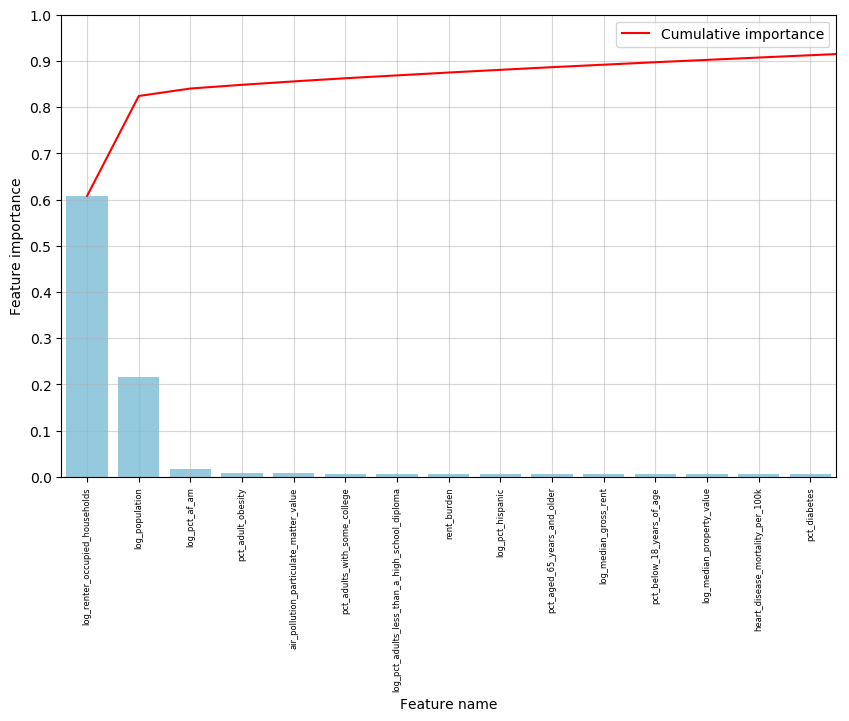

In [69]:
plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

**Select 20 most important features**

In [70]:
most_imp_feats = feat_import_df.iloc[:20, 0].values

<br>
<br>

**Fit on 20 most important features**

In [71]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [72]:
train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

In [73]:
feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['log_evictions'].values

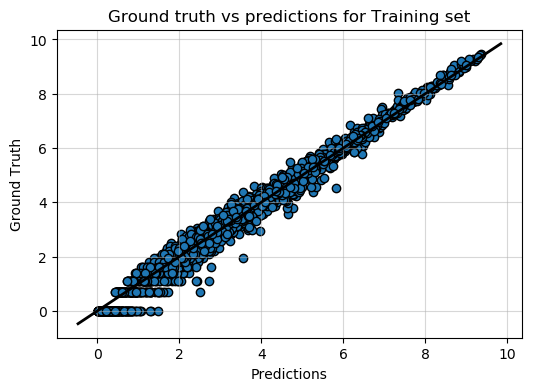

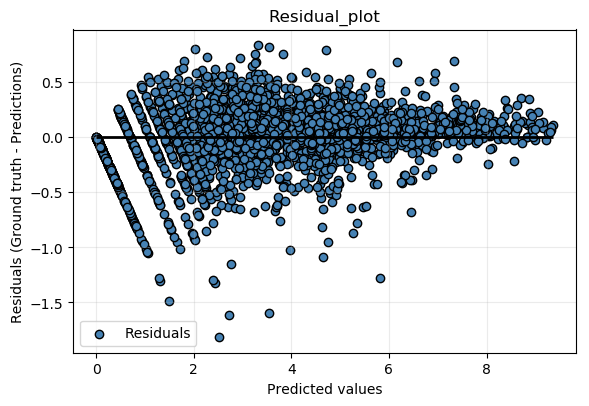

In [74]:
rand_forest = RandomForestRegressor(n_estimators=1000, 
                                    criterion='mse', 
                                    max_depth=15, 
                                    n_jobs=4,)

rand_forest.fit(X_train, y_train)
y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [75]:
from sklearn.metrics import r2_score

y_train = np.exp(y_train)-1
y_pred_train = np.exp(y_pred_train) - 1

r2_score(y_train, y_pred_train)

0.9790274117484644

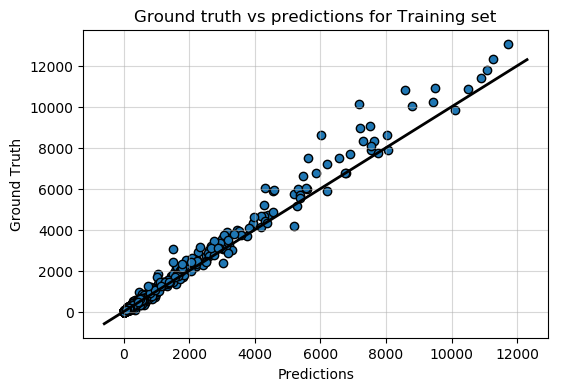

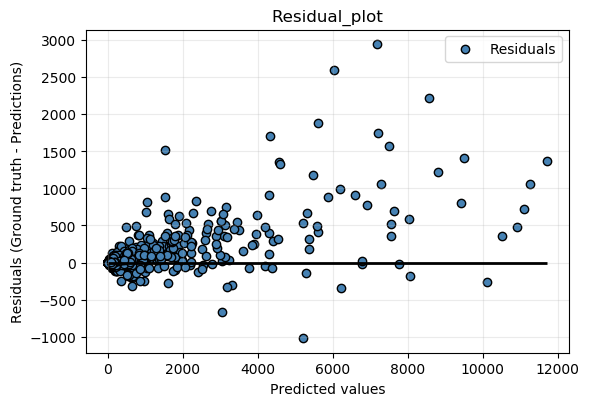

In [76]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

<br>
<br>

**Get submission**

In [77]:
X_test.shape

(2420, 20)

In [78]:
y_pred_test = rand_forest.predict(X_test)
y_pred_test = np.exp(y_pred_test) - 1

In [79]:
y_pred_test

array([1.04206334e+03, 1.29928889e+02, 9.00117781e-01, ...,
       3.16483015e+02, 1.86086649e+02, 1.61715365e+02])

In [80]:
submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)

In [82]:
submission.to_csv("1_24012019_submission.csv", index=False)

<br>
<br>

# 2.

In [63]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [64]:
y_train = train_labels['evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [65]:
from sklearn.ensemble import RandomForestRegressor

## Most "important" features

In [66]:
from sklearn.ensemble import RandomForestRegressor

feat_imp_forest = RandomForestRegressor(n_estimators=500, 
                                        criterion='mse', 
                                        max_depth=9, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [67]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) log_renter_occupied_households 0.476389
 2) log_population                 0.227422
 3) log_poverty_rate               0.044691
 4) log_pct_af_am                  0.044319
 5) log_median_property_value      0.033317
 6) heart_disease_mortality_per_100k 0.013440
 7) log_motor_vehicle_crash_deaths_per_100k 0.009660
 8) log_pct_multiple               0.009289
 9) rent_burden                    0.008516
10) pct_civilian_labor             0.008148
11) log_pct_am_ind                 0.006995
12) log_median_gross_rent          0.006371
13) log_pct_low_birthweight        0.006297
14) pct_physical_inactivity        0.006154
15) log_median_household_income    0.005982
16) log_pct_other                  0.005708
17) pct_below_18_years_of_age      0.005497
18) pct_adults_with_high_school_diploma 0.005267
19) pct_adult_obesity              0.004922
20) log_pct_renter_occupied        0.004787
21) death_rate_per_1k              0.004620
22) pct_diabetes                   0.004529
23) log_pct_nh_p

Make a DataFrame of feature importances

In [68]:
feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()
feat_import_df

Feature name  Feature importance  \
0                      log_renter_occupied_households        4.763889e-01   
1                                      log_population        2.274223e-01   
2                                    log_poverty_rate        4.469119e-02   
3                                       log_pct_af_am        4.431949e-02   
4                           log_median_property_value        3.331746e-02   
5                    heart_disease_mortality_per_100k        1.343986e-02   
6             log_motor_vehicle_crash_deaths_per_100k        9.660089e-03   
7                                    log_pct_multiple        9.289397e-03   
8                                         rent_burden        8.516410e-03   
9                                  pct_civilian_labor        8.148251e-03   
10                                     log_pct_am_ind        6.994757e-03   
11                              log_median_gross_rent        6.370981e-03   
12                            log_pct_low_birthweight        6.296787e-03   
13                            pct_physical_inactivity        6.154124e-03   
14                        log_median_household_income        5.981992e-03   
15                                      log_pct_other        5.707524e-03   
16                          pct_below_18_years_of_age        5.497105e-03   
17                pct_adults_with_high_school_diploma        5.266595e-03   
18                                  pct_adult_obesity        4.921677e-03   
19                            log_pct_renter_occupied        4.787155e-03   
20                                  death_rate_per_1k        4.619732e-03   
21                                       pct_diabetes        4.528508e-03   
22                                      log_pct_nh_pi        4.378421e-03   
23                       pct_adults_with_some_college        3.965164e-03   
24                                log_pop_per_dentist        3.907957e-03   
25                               log_pct_unemployment        3.650949e-03   
26             air_pollution_particulate_matter_value        3.584532e-03   
27                             pct_excessive_drinking        3.437834e-03   
28                                   log_pct_hispanic        3.194838e-03   
29     log_pct_adults_less_than_a_high_school_diploma        3.192202e-03   
..                                                ...                 ...   
34                                  pct_adult_smoking        2.700190e-03   
35                              log_birth_rate_per_1k        2.633258e-03   
36                 log_pct_adults_bachelors_or_higher        2.592683e-03   
37                               pct_uninsured_adults        2.285122e-03   
38                                         pct_female        2.079919e-03   
39                 log_pop_per_primary_care_physician        1.944855e-03   
40                 economic_typology_Mining-dependent        1.110982e-03   
41                   economic_typology_Nonspecialized        3.894248e-04   
42                       economic_typology_Recreation        2.672509e-04   
43  urban_influence_Small-in a metro area with few...        2.583559e-04   
44  economic_typology_Federal/State government-dep...        2.199310e-04   
45  rucc_Metro - Counties in metro areas of 250,00...        9.587859e-05   
46          economic_typology_Manufacturing-dependent        4.780379e-05   
47  rucc_Metro - Counties in metro areas of fewer ...        4.666745e-05   
48  urban_influence_Micropolitan adjacent to a lar...        9.358342e-06   
49  rucc_Nonmetro - Urban population of 20,000 or ...        6.325276e-06   
50  urban_influence_Micropolitan adjacent to a sma...        1.282468e-06   
51  rucc_Nonmetro - Urban population of 2,500 to 1...        3.876190e-07   
52  urban_influence_Micropolitan not adjacent to a...        3.132212e-07   
53  urban_influence_Noncore adjacent to a large me...        2.150704e-07   
54  urban_influence_Noncore not adjac

Plot the 15 most important features

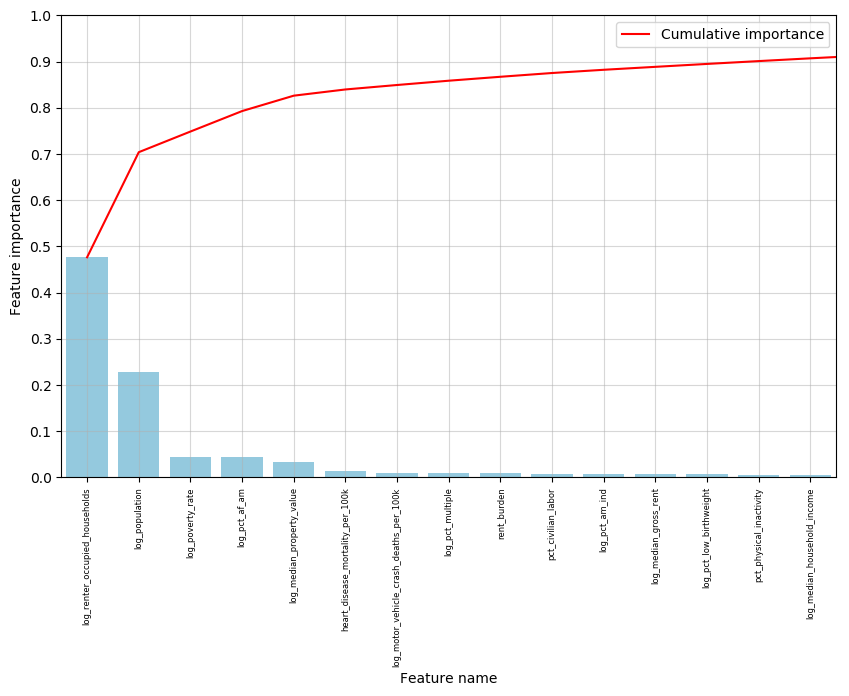

In [69]:
plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

**Select 20 most important features**

In [70]:
most_imp_feats = feat_import_df.iloc[:20, 0].values

<br>
<br>

**Fit on 20 most important features**

In [71]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [72]:
train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

In [73]:
feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['evictions'].values

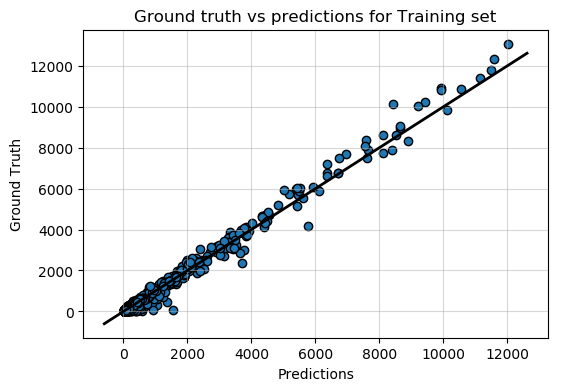

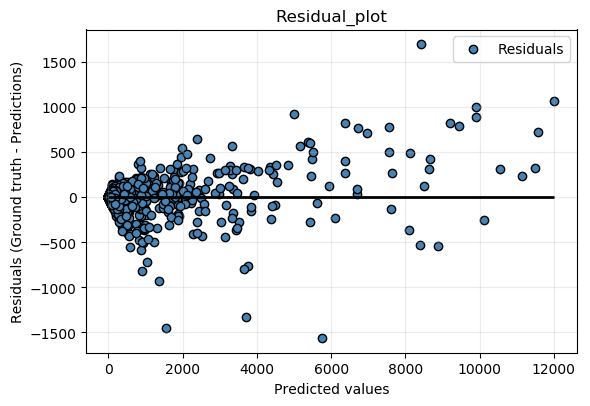

In [74]:
rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=4,)

rand_forest.fit(X_train, y_train)
y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [75]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=1)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

R2: 0.894 +/- 0.054


<br>
<br>

**Get submission**

In [76]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(2544, 20)
(2544,)
(2420, 20)


In [77]:
y_pred_test = rand_forest.predict(X_test)
y_pred_test

array([1.00755362e+03, 2.83500309e+02, 7.93912362e-01, ...,
       6.26265393e+02, 2.29699525e+02, 4.52325696e+02])

In [78]:
submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission['evictions']

0       1007
1        283
2          0
3         15
4        179
5        293
6          4
7        138
8       2265
9         55
10      2106
11        26
12        65
13         4
14        40
15      1675
16       451
17        14
18        55
19        14
20        90
21      1189
22         0
23        30
24       403
25        15
26       476
27        10
28         4
29      2572
        ... 
2390      16
2391      89
2392      83
2393      11
2394       2
2395     210
2396      10
2397     625
2398       0
2399       0
2400       0
2401       2
2402      24
2403      49
2404      41
2405       4
2406      16
2407       0
2408       7
2409      56
2410      53
2411      14
2412      20
2413     140
2414      17
2415     105
2416      86
2417     626
2418     229
2419     452
Name: evictions, Length: 2420, dtype: int32

<br>
<br>

In [79]:
submission.to_csv("2_24012019_submission.csv", index=False)

<br>
<br>

# 3

In [65]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [66]:
y_train = train_labels['evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [67]:
from sklearn.ensemble import RandomForestRegressor

## Most "important" features

In [68]:
from sklearn.ensemble import RandomForestRegressor

feat_imp_forest = RandomForestRegressor(n_estimators=500, 
                                        criterion='mse', 
                                        max_depth=15, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [69]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) log_renter_occupied_households 0.542292
 2) log_population                 0.089515
 3) log_pct_af_am                  0.076962
 4) pct_adults_with_some_college   0.015971
 5) log_pct_low_birthweight        0.015348
 6) log_poverty_rate               0.014470
 7) pct_adults_with_high_school_diploma 0.014170
 8) log_motor_vehicle_crash_deaths_per_100k 0.012069
 9) log_pct_other                  0.011683
10) log_median_property_value      0.010872
11) log_pct_adults_less_than_a_high_school_diploma 0.010692
12) pct_adult_obesity              0.010213
13) log_pop_per_dentist            0.010141
14) log_pct_uninsured_children     0.009847
15) air_pollution_particulate_matter_value 0.009293
16) pct_white                      0.009185
17) log_pct_multiple               0.009023
18) rent_burden                    0.008448
19) pct_uninsured_adults           0.008361
20) log_pct_am_ind                 0.007722
21) log_pct_hispanic               0.007150
22) log_pop_per_primary_care_physician

Make a DataFrame of feature importances

In [70]:
feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()
feat_import_df

Feature name  Feature importance  \
0                      log_renter_occupied_households        5.422925e-01   
1                                      log_population        8.951526e-02   
2                                       log_pct_af_am        7.696160e-02   
3                        pct_adults_with_some_college        1.597085e-02   
4                             log_pct_low_birthweight        1.534835e-02   
5                                    log_poverty_rate        1.447014e-02   
6                 pct_adults_with_high_school_diploma        1.417046e-02   
7             log_motor_vehicle_crash_deaths_per_100k        1.206924e-02   
8                                       log_pct_other        1.168310e-02   
9                           log_median_property_value        1.087172e-02   
10     log_pct_adults_less_than_a_high_school_diploma        1.069231e-02   
11                                  pct_adult_obesity        1.021308e-02   
12                                log_pop_per_dentist        1.014145e-02   
13                         log_pct_uninsured_children        9.846517e-03   
14             air_pollution_particulate_matter_value        9.293470e-03   
15                                          pct_white        9.185406e-03   
16                                   log_pct_multiple        9.022518e-03   
17                                        rent_burden        8.448154e-03   
18                               pct_uninsured_adults        8.360697e-03   
19                                     log_pct_am_ind        7.722392e-03   
20                                   log_pct_hispanic        7.149755e-03   
21                 log_pop_per_primary_care_physician        6.623972e-03   
22                              log_median_gross_rent        6.611224e-03   
23                        log_median_household_income        6.533148e-03   
24                             pct_excessive_drinking        6.142050e-03   
25                   heart_disease_mortality_per_100k        5.852791e-03   
26                            log_pct_renter_occupied        5.804376e-03   
27                                  pct_adult_smoking        5.798661e-03   
28                                      log_pct_asian        5.356360e-03   
29                            pct_physical_inactivity        5.198687e-03   
..                                                ...                 ...   
34                                  death_rate_per_1k        4.051856e-03   
35                 log_pct_adults_bachelors_or_higher        3.993823e-03   
36                        pct_aged_65_years_and_older        3.712767e-03   
37                                         pct_female        3.572830e-03   
38                              log_birth_rate_per_1k        3.453538e-03   
39                               log_pct_unemployment        3.005772e-03   
40  rucc_Metro - Counties in metro areas of 250,00...        3.813487e-04   
41  urban_influence_Small-in a metro area with few...        3.793722e-04   
42  economic_typology_Federal/State government-dep...        3.331998e-04   
43                   economic_typology_Nonspecialized        3.290559e-04   
44          economic_typology_Manufacturing-dependent        2.548454e-04   
45  rucc_Metro - Counties in metro areas of fewer ...        1.670484e-04   
46                       economic_typology_Recreation        6.560537e-05   
47  urban_influence_Micropolitan adjacent to a lar...        6.013483e-05   
48  rucc_Nonmetro - Urban population of 20,000 or ...        4.072627e-05   
49  urban_influence_Micropolitan adjacent to a sma...        2.017771e-05   
50  rucc_Nonmetro - Urban population of 2,500 to 1...        8.857602e-06   
51  urban_influence_Micropolitan not adjacent to a...        7.189092e-06   
52                 economic_typology_Mining-dependent        6.339305e-06   
53  rucc_Nonmetro - Urban population of 20,000 or ...        5.055471e-06   
54  rucc_Nonmetro - Urban population 

Plot the 15 most important features

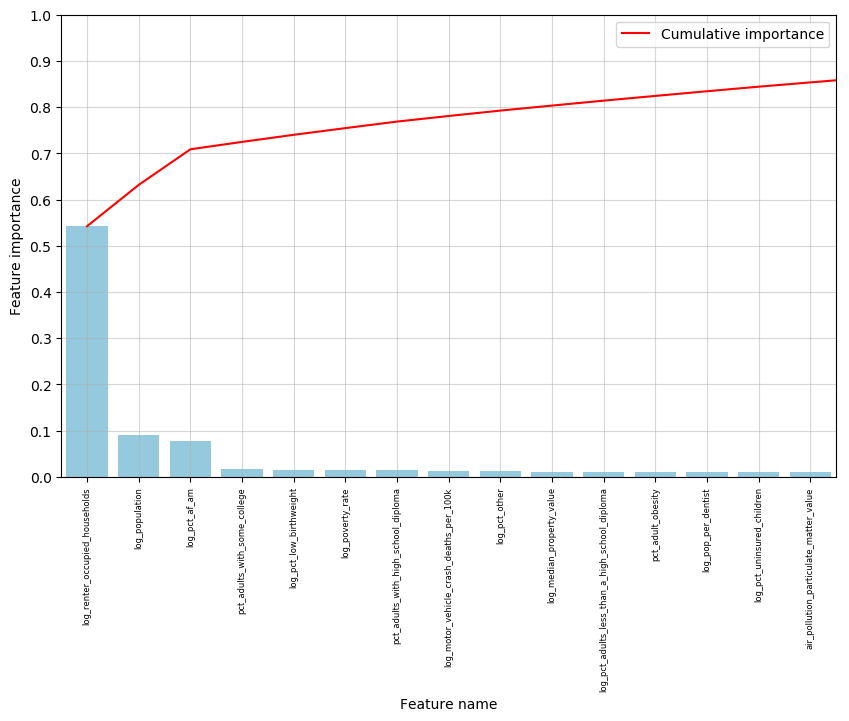

In [71]:
plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

**Select most important features**

In [72]:
most_imp_feats = feat_import_df.iloc[:30, 0].values

<br>
<br>

**Fit on most important features**

In [73]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [74]:
train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

In [75]:
feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['evictions'].values

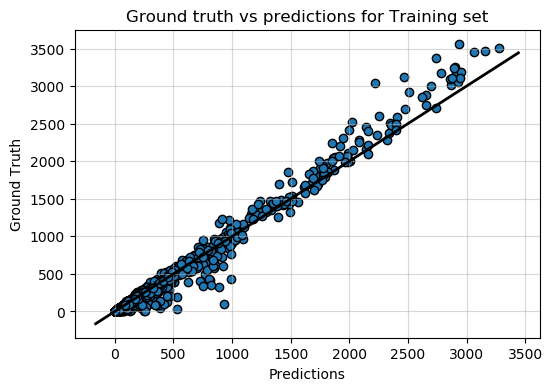

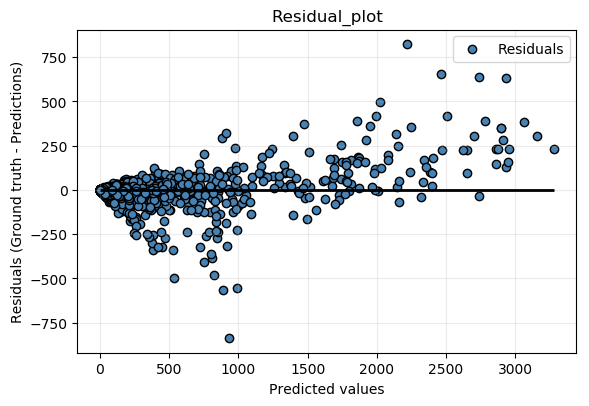

In [76]:
rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=15, 
                                    n_jobs=3,)

rand_forest.fit(X_train, y_train)
y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

<br>
<br>

In [77]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

# R2: 0.818 +/- 0.051 (97.5%, max depth=11, 30 features)
# R2: 0.825 +/- 0.049 (97.5%, max depth=9, 21 features)
# R2: 0.825 +/- 0.047 (97.5%, max depth=15, 30 features)
# R2: 0.828 +/- 0.049 (97.5%, max depth=12, 21 features)
# R2: 0.824 +/- 0.052 (97.5%, max depth=11, 21 features)
# R2: 0.811 +/- 0.052 (97.5%, max depth=12, 40 features)

# R2: 0.790 +/- 0.064 (95%, max depth=15, 25 features)
# R2: 0.793 +/- 0.065 (95%, max depth=15, 30 features)
# R2: 0.785 +/- 0.061 (95%, max depth=9, 20 features)
# R2: 0.793 +/- 0.063 (95%, max depth=15, 25 features)

# R2: 0.823 +/- 0.052 (97.5, 11, 21)
# R2: 0.825 +/- 0.048 (97.5, 15, 30)
# R2: 0.825 +/- 0.045 (97.5, 15, 30)

R2: 0.825 +/- 0.045


In [78]:
# 97.5
print(X_train.shape)

(2482, 30)


<br>
<br>

**Get submission**

In [79]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(2482, 30)
(2482,)
(2420, 30)


In [80]:
y_pred_test = rand_forest.predict(X_test)
y_pred_test

array([1.05380200e+03, 2.22902797e+02, 9.84717613e-01, ...,
       6.38104915e+02, 2.26388825e+02, 4.47624695e+02])

In [81]:
submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission['evictions']

0       1053
1        222
2          0
3         12
4        202
5        307
6          4
7        160
8       1756
9         54
10      1574
11        26
12        61
13         4
14        44
15      1878
16       409
17        11
18        59
19        11
20       101
21      1140
22         1
23        25
24       354
25        16
26       312
27        10
28         3
29      1799
        ... 
2390      17
2391      75
2392      93
2393       9
2394       2
2395     216
2396      12
2397     618
2398       0
2399       0
2400       0
2401       2
2402      23
2403      46
2404      41
2405       5
2406      19
2407       0
2408       5
2409      46
2410      61
2411      13
2412      24
2413     142
2414      14
2415     119
2416     108
2417     638
2418     226
2419     447
Name: evictions, Length: 2420, dtype: int32

In [82]:
submission.to_csv("3_24012019_submission.csv", index=False)

Very poor performance

<br>
<br>

Fitting on the log label resulted in poor performance (heavily overfitted) however, removing >97.5%ile extreme values resulted in very poor performance (0.4 R2). Best single model (Random Forest) performance resulted from removing the two most extreme points, and selecting 20 features (0.75 R2).

Because removing the extreme points resulted in such a big performance hit. it is likely that the training points with high eviction values should have a big influence on how the model should act at such extreme ranges.

Therefore for tomorrow's 3 attempts:

1. Keep all points, add extra weight to the extreme points, feature selection (20?), Random Forest.

If the above model performs worse than the best single model achieved from 2-24012019:

2. Remove the two most extreme points, select the SAME features as the ones selected from 2-24012019, and produce an averaging ensemble

3. ??

else

2. Produce an averaging ensemble of models using the same features and weighted points as 1 above

3. ??

<br>
<br>

# 1.

In [65]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [66]:
y_train = train_labels['evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [67]:
from sklearn.ensemble import RandomForestRegressor

## Most "important" features

In [68]:
from sklearn.ensemble import RandomForestRegressor

feat_imp_forest = RandomForestRegressor(n_estimators=500, 
                                        criterion='mse', 
                                        max_depth=9, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [69]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) log_renter_occupied_households 0.346601
 2) log_population                 0.331329
 3) economic_typology_Mining-dependent 0.050409
 4) log_poverty_rate               0.038521
 5) log_pct_af_am                  0.033803
 6) pct_aged_65_years_and_older    0.021783
 7) log_median_property_value      0.017573
 8) log_pct_multiple               0.012877
 9) log_pct_uninsured_children     0.010539
10) heart_disease_mortality_per_100k 0.009423
11) death_rate_per_1k              0.007217
12) rent_burden                    0.006732
13) pct_civilian_labor             0.006669
14) log_birth_rate_per_1k          0.006475
15) log_motor_vehicle_crash_deaths_per_100k 0.006194
16) log_pct_am_ind                 0.005701
17) log_pct_low_birthweight        0.005479
18) pct_below_18_years_of_age      0.005137
19) pct_physical_inactivity        0.004898
20) log_median_gross_rent          0.004812
21) log_pct_other                  0.004460
22) log_median_household_income    0.004349
23) pct_female   

Make a DataFrame of feature importances

In [70]:
feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()
feat_import_df

Feature name  Feature importance  \
0                      log_renter_occupied_households        3.466012e-01   
1                                      log_population        3.313292e-01   
2                  economic_typology_Mining-dependent        5.040854e-02   
3                                    log_poverty_rate        3.852128e-02   
4                                       log_pct_af_am        3.380326e-02   
5                         pct_aged_65_years_and_older        2.178295e-02   
6                           log_median_property_value        1.757337e-02   
7                                    log_pct_multiple        1.287732e-02   
8                          log_pct_uninsured_children        1.053926e-02   
9                    heart_disease_mortality_per_100k        9.423240e-03   
10                                  death_rate_per_1k        7.216937e-03   
11                                        rent_burden        6.731798e-03   
12                                 pct_civilian_labor        6.669051e-03   
13                              log_birth_rate_per_1k        6.475079e-03   
14            log_motor_vehicle_crash_deaths_per_100k        6.194278e-03   
15                                     log_pct_am_ind        5.701126e-03   
16                            log_pct_low_birthweight        5.478706e-03   
17                          pct_below_18_years_of_age        5.137404e-03   
18                            pct_physical_inactivity        4.897691e-03   
19                              log_median_gross_rent        4.812499e-03   
20                                      log_pct_other        4.459507e-03   
21                        log_median_household_income        4.348516e-03   
22                                         pct_female        4.250884e-03   
23                                  pct_adult_obesity        4.166515e-03   
24                pct_adults_with_high_school_diploma        4.145192e-03   
25                                      log_pct_nh_pi        3.512156e-03   
26                                       pct_diabetes        3.483035e-03   
27                            log_pct_renter_occupied        3.451958e-03   
28                                   log_pct_hispanic        3.433722e-03   
29             air_pollution_particulate_matter_value        3.318139e-03   
..                                                ...                 ...   
34                             pct_excessive_drinking        2.575367e-03   
35                               log_pct_unemployment        2.549599e-03   
36                                      log_pct_asian        2.243347e-03   
37     log_pct_adults_less_than_a_high_school_diploma        2.222538e-03   
38                 log_pct_adults_bachelors_or_higher        2.192788e-03   
39                               pct_uninsured_adults        2.055934e-03   
40                                          pct_white        1.933179e-03   
41                   economic_typology_Nonspecialized        1.493929e-03   
42  urban_influence_Small-in a metro area with few...        1.374280e-04   
43  economic_typology_Federal/State government-dep...        8.901050e-05   
44  rucc_Metro - Counties in metro areas of 250,00...        6.584677e-05   
45          economic_typology_Manufacturing-dependent        5.119814e-05   
46                       economic_typology_Recreation        4.333423e-05   
47  rucc_Metro - Counties in metro areas of fewer ...        3.324450e-05   
48  urban_influence_Micropolitan adjacent to a lar...        7.202750e-06   
49  urban_influence_Micropolitan adjacent to a sma...        3.133486e-06   
50  rucc_Nonmetro - Urban population of 20,000 or ...        2.111183e-06   
51  rucc_Nonmetro - Urban population of 20,000 or ...        1.154155e-06   
52  urban_influence_Micropolitan not adjacent to a...        4.786516e-07   
53  rucc_Nonmetro - Urban population of 2,500 to 1...        1.304306e-07   
54  rucc_Nonmetro - Urban population 

Plot the 15 most important features

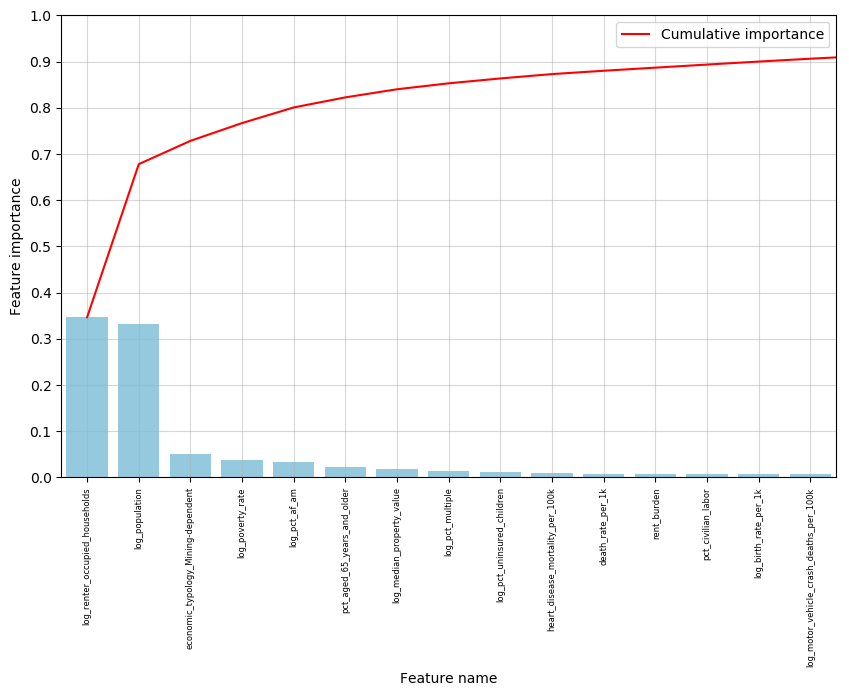

In [71]:
plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

**Select 20 most important features**

In [72]:
most_imp_feats = feat_import_df.iloc[:20, 0].values

<br>
<br>

**Fit on 20 most important features**

In [73]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

train_data_tranf = pd.get_dummies(train_data_tranf, drop_first=True)
test_data_tranf = pd.get_dummies(test_data_tranf, drop_first=True)

In [74]:
train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

In [75]:
feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['evictions'].values

In [76]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>16000)] += 14

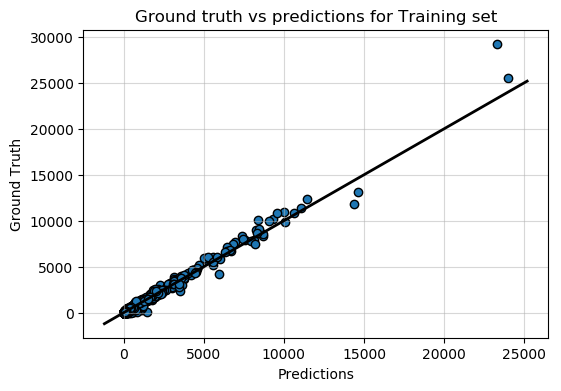

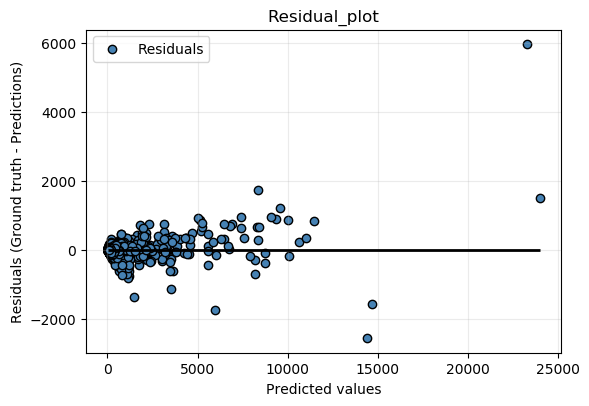

In [77]:
rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=3,)

rand_forest.fit(X_train, y_train, sample_weights)

y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [ ]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

<br>
<br>

In [80]:
y_pred_test = rand_forest.predict(X_test)
y_pred_test

array([894.88731296, 199.04627611,   1.08354821, ..., 545.07551009,
       233.44667407, 394.60572719])

In [81]:
submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission['evictions']

0        894
1        199
2          1
3         15
4        184
5        300
6          4
7        133
8       2299
9         54
10      2586
11        26
12        63
13         4
14        38
15      1871
16       422
17        14
18        61
19        14
20        84
21      1085
22         0
23        35
24       416
25        15
26       561
27        12
28         4
29      2762
        ... 
2390      16
2391      89
2392      83
2393      12
2394       3
2395     233
2396      11
2397     557
2398       0
2399       0
2400       0
2401       1
2402      28
2403      62
2404      41
2405       5
2406      15
2407       0
2408       8
2409      60
2410      49
2411      15
2412      20
2413     144
2414      18
2415      99
2416      98
2417     545
2418     233
2419     394
Name: evictions, Length: 2420, dtype: int32

In [82]:
submission.to_csv("1_22012019_submission.csv", index=False)

**0.8200**

<br>
<br>

# 2. Averaging Ensemble

In [65]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [66]:
y_train = train_labels['evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [67]:
from sklearn.ensemble import RandomForestRegressor

**Most "important" features**

In [68]:
from sklearn.ensemble import RandomForestRegressor

feat_imp_forest = RandomForestRegressor(n_estimators=750, 
                                        criterion='mse', 
                                        max_depth=15, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [69]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) log_renter_occupied_households 0.366288
 2) log_population                 0.301974
 3) economic_typology_Mining-dependent 0.052154
 4) log_poverty_rate               0.034820
 5) log_pct_af_am                  0.032962
 6) pct_aged_65_years_and_older    0.025089
 7) log_median_property_value      0.020008
 8) death_rate_per_1k              0.011105
 9) log_pct_uninsured_children     0.011104
10) log_pct_multiple               0.010736
11) heart_disease_mortality_per_100k 0.010625
12) rent_burden                    0.006784
13) log_birth_rate_per_1k          0.006736
14) log_motor_vehicle_crash_deaths_per_100k 0.006487
15) pct_below_18_years_of_age      0.006297
16) pct_civilian_labor             0.006054
17) pct_physical_inactivity        0.005593
18) log_pct_low_birthweight        0.005453
19) log_pct_other                  0.005214
20) log_pct_am_ind                 0.005026
21) pct_adult_obesity              0.004690
22) pct_female                     0.004417
23) pct_adults_wi

Make a DataFrame of feature importances

In [70]:
feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()
feat_import_df

Feature name  Feature importance  \
0                      log_renter_occupied_households        3.662883e-01   
1                                      log_population        3.019739e-01   
2                  economic_typology_Mining-dependent        5.215381e-02   
3                                    log_poverty_rate        3.482046e-02   
4                                       log_pct_af_am        3.296189e-02   
5                         pct_aged_65_years_and_older        2.508900e-02   
6                           log_median_property_value        2.000829e-02   
7                                   death_rate_per_1k        1.110539e-02   
8                          log_pct_uninsured_children        1.110413e-02   
9                                    log_pct_multiple        1.073621e-02   
10                   heart_disease_mortality_per_100k        1.062537e-02   
11                                        rent_burden        6.784483e-03   
12                              log_birth_rate_per_1k        6.735691e-03   
13            log_motor_vehicle_crash_deaths_per_100k        6.487295e-03   
14                          pct_below_18_years_of_age        6.297235e-03   
15                                 pct_civilian_labor        6.053747e-03   
16                            pct_physical_inactivity        5.593450e-03   
17                            log_pct_low_birthweight        5.453257e-03   
18                                      log_pct_other        5.214035e-03   
19                                     log_pct_am_ind        5.025504e-03   
20                                  pct_adult_obesity        4.689992e-03   
21                                         pct_female        4.416952e-03   
22                pct_adults_with_high_school_diploma        4.339410e-03   
23                              log_median_gross_rent        4.283286e-03   
24                        log_median_household_income        4.075879e-03   
25                                       pct_diabetes        3.738315e-03   
26                                   log_pct_hispanic        3.566299e-03   
27                                log_pop_per_dentist        3.371088e-03   
28                            log_pct_renter_occupied        3.204088e-03   
29             air_pollution_particulate_matter_value        3.149801e-03   
..                                                ...                 ...   
34                   economic_typology_Nonspecialized        2.665337e-03   
35     log_pct_adults_less_than_a_high_school_diploma        2.408964e-03   
36                 log_pop_per_primary_care_physician        2.354386e-03   
37                                          pct_white        2.329932e-03   
38                                  pct_adult_smoking        2.326314e-03   
39                 log_pct_adults_bachelors_or_higher        2.234363e-03   
40                                      log_pct_asian        2.145633e-03   
41                               pct_uninsured_adults        2.049011e-03   
42  urban_influence_Small-in a metro area with few...        2.223535e-04   
43                       economic_typology_Recreation        1.388523e-04   
44  rucc_Metro - Counties in metro areas of 250,00...        1.070543e-04   
45  economic_typology_Federal/State government-dep...        1.001875e-04   
46          economic_typology_Manufacturing-dependent        4.648793e-05   
47  rucc_Metro - Counties in metro areas of fewer ...        3.821164e-05   
48  urban_influence_Micropolitan adjacent to a lar...        8.424471e-06   
49  rucc_Nonmetro - Urban population of 20,000 or ...        4.942548e-06   
50  urban_influence_Micropolitan adjacent to a sma...        3.627442e-06   
51  rucc_Nonmetro - Urban population of 2,500 to 1...        1.028440e-06   
52  rucc_Nonmetro - Urban population of 20,000 or ...        9.310674e-07   
53  urban_influence_Micropolitan not adjacent to a...        7.600637e-07   
54  rucc_Nonmetro - Urban population 

Plot the 15 most important features

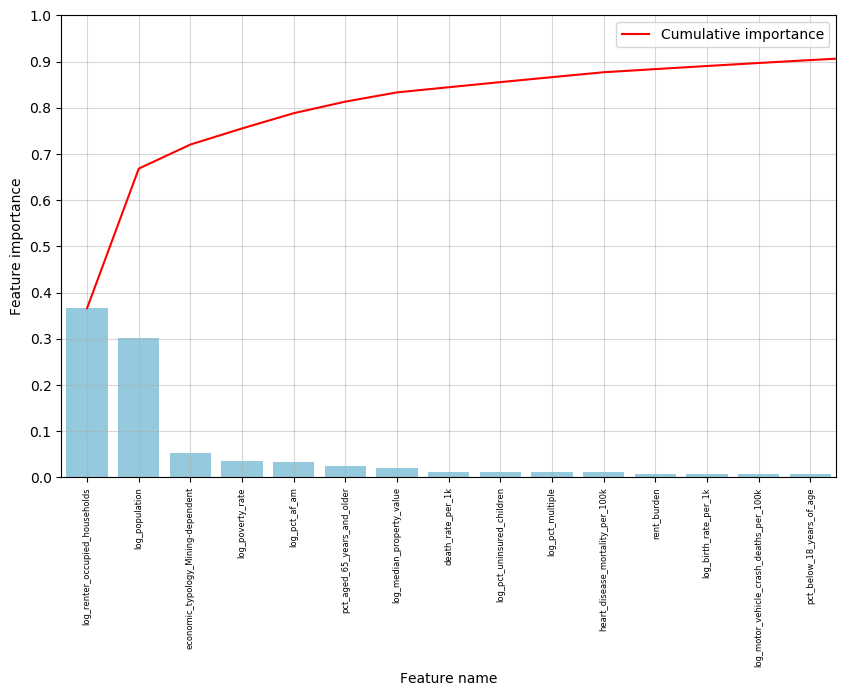

In [71]:
plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

**Select 20 most important features**

In [72]:
most_imp_feats = feat_import_df.iloc[:20, 0].values

<br>
<br>

**Fit on 20 most important features**

In [73]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

train_data_tranf = pd.get_dummies(train_data_tranf, drop_first=True)
test_data_tranf = pd.get_dummies(test_data_tranf, drop_first=True)

In [74]:
train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

In [75]:
feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['evictions'].values

<br>
<br>

In [76]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>16000)] += 49

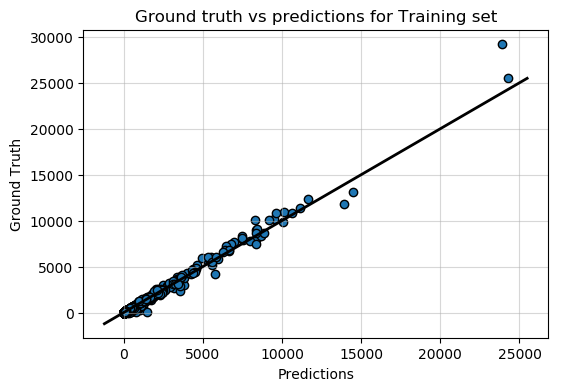

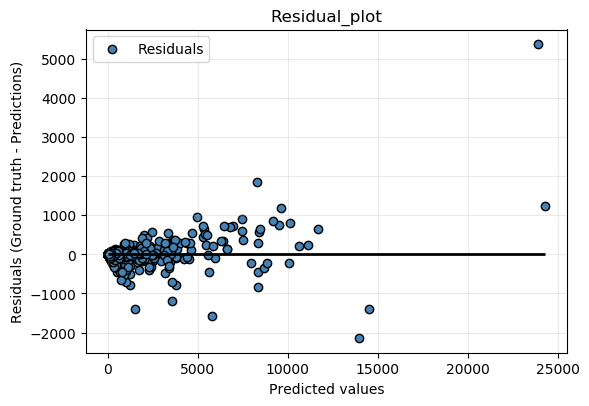

In [77]:
rand_forest = RandomForestRegressor(n_estimators=750, 
                                    criterion='mse', 
                                    max_depth=15, 
                                    n_jobs=3,)

rand_forest.fit(X_train, y_train, sample_weights)

y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [78]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

R2: 0.874 +/- 0.071


In [79]:
y_pred_test_rf1 = rand_forest.predict(X_test)

<br>
<br>

**XGBoost**

In [130]:
train_labels['evictions'].quantile(1.0)

29251.0

In [80]:
from xgboost import XGBRegressor

In [138]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train<676)] += 1
sample_weights[np.argwhere(y_train<1876)] += 1
sample_weights[np.argwhere(y_train<3571)] += 2
sample_weights[np.argwhere(y_train>16000)] += 0

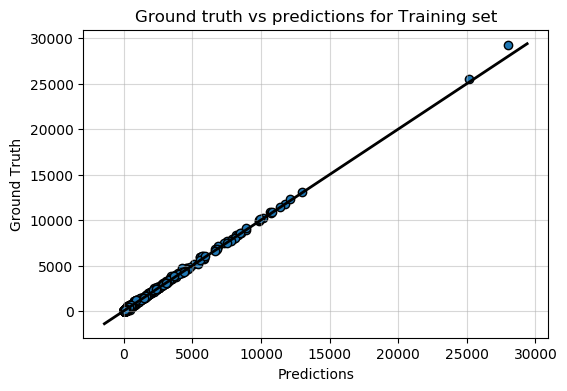

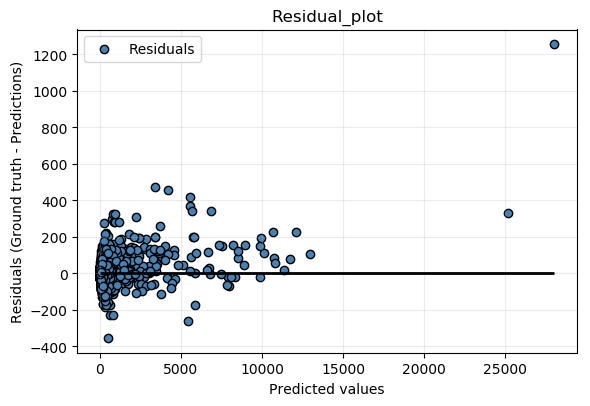

In [141]:
xgb_regr = XGBRegressor(learning_rate=0.03, 
                        n_estimators=200,
                        max_depth=7,
                        n_jobs=4)

xgb_regr.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_train = xgb_regr.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [142]:
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(xgb_regr, X_train, y_train, scoring='r2', cv=10, n_jobs=1)

print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

# R2: 0.899 +/- 0.067

R2: 0.899 +/- 0.069


In [84]:
y_pred_test_xgb = xgb_regr.predict(X_test)

<br>
<br>

**Random Forest 2**

In [85]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train>16000)] += 14

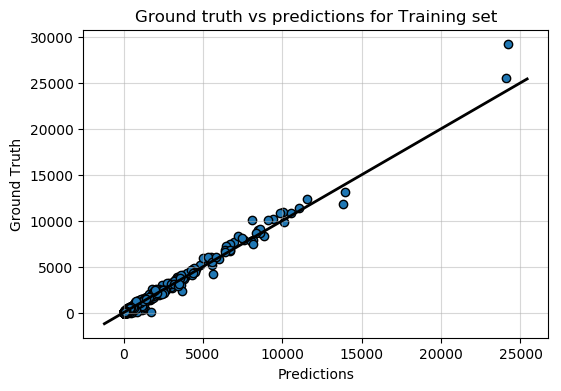

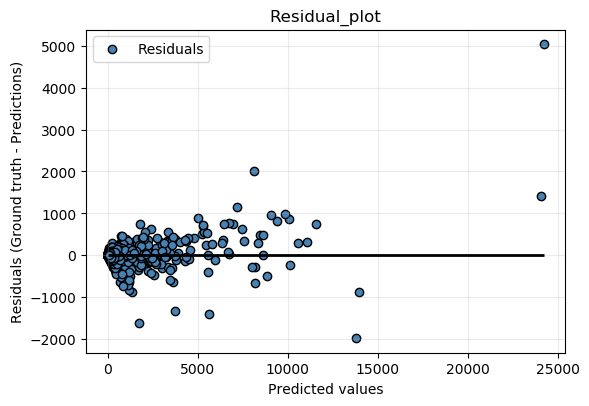

In [86]:
rand_forest = RandomForestRegressor(n_estimators=500, 
                                    criterion='mse', 
                                    max_depth=9, 
                                    n_jobs=3,)

rand_forest.fit(X_train, y_train, sample_weights)

y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [87]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

R2: 0.874 +/- 0.069


In [88]:
y_pred_test_rf2 = rand_forest.predict(X_test)

<br>
<br>

**GBDT**

In [89]:
from sklearn.ensemble import GradientBoostingRegressor

In [90]:
sample_weights = np.ones_like(y_train)
sample_weights[np.argwhere(y_train<676)] += 1
sample_weights[np.argwhere(y_train<1876)] += 1
sample_weights[np.argwhere(y_train<3571)] += 6
sample_weights[np.argwhere(y_train>16000)] += 0

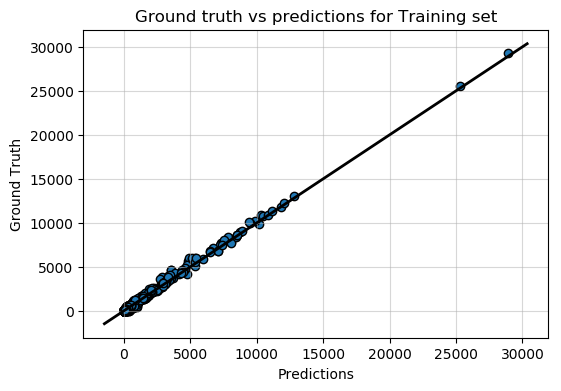

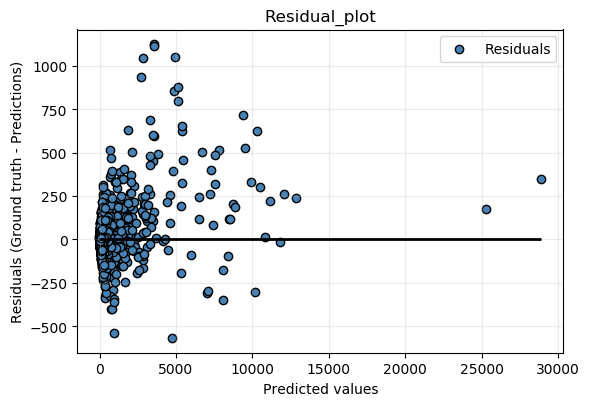

In [91]:
grad_boost_regr = GradientBoostingRegressor(loss='ls', 
                                            learning_rate=0.03, 
                                            n_estimators=200, 
                                            max_depth=5)

grad_boost_regr.fit(X_train, y_train, sample_weights)
y_pred_train = grad_boost_regr.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [92]:
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(grad_boost_regr, X_train, y_train, scoring='r2', cv=10, n_jobs=2)

print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

# R2: 0.901 +/- 0.068

R2: 0.899 +/- 0.070


In [93]:
y_pred_test_gbdt = grad_boost_regr.predict(X_test)

<br>
<br>

In [94]:
print(y_pred_test_rf1)
print(y_pred_test_rf2)
print(y_pred_test_gbdt)
print(y_pred_test_xgb)

[900.33779625 247.11590616   1.92322997 ... 617.83775436 261.43039778
 423.1108057 ]
[859.33795213 243.54483231   1.07707166 ... 592.16738985 241.67666691
 412.19292443]
[972.30707074 262.88446859   5.54156049 ... 383.22492332 219.13095698
 270.33296156]
[748.13824   325.20084     2.6272151 ... 481.18402   232.81665
 262.14276  ]


In [95]:
y_pred_test = (y_pred_test_rf1 + y_pred_test_rf2 + y_pred_test_gbdt + y_pred_test_xgb)/4

<br>
<br>

In [96]:
submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission['evictions']

0        870
1        269
2          2
3         15
4        161
5        275
6          5
7        150
8       1825
9         51
10      2614
11        19
12        68
13         7
14        34
15      1939
16       396
17        13
18        50
19        13
20        91
21      1339
22         1
23        26
24       453
25        18
26       513
27        11
28         5
29      2599
        ... 
2390      21
2391      81
2392      79
2393      11
2394       3
2395     283
2396      11
2397     552
2398       2
2399       2
2400       3
2401       2
2402      23
2403      52
2404      42
2405       5
2406      12
2407       1
2408       8
2409      54
2410      53
2411      15
2412      22
2413     137
2414      19
2415     109
2416      87
2417     518
2418     238
2419     341
Name: evictions, Length: 2420, dtype: int32

<br>
<br>

In [97]:
submission.to_csv("2_25012019_submission.csv", index=False)

**0.8256**

<br>
<br>

# 3. Averaging 2nd attempt

In [65]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

X = pd.read_csv("train_values.csv")
states = X['state'].values
del(X)

In [66]:
y_train = train_labels['evictions'].values

X_train_cat = train_data_tranf.iloc[:,:3]
X_test_cat = test_data_tranf.iloc[:,:3]

X_train = train_data_tranf.iloc[:,3:].values
X_test = test_data_tranf.iloc[:,3:].values
feat_labels = train_data_tranf.iloc[:,3:].columns.tolist()

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True).astype('float64')
feat_labels = feat_labels + X_train_cat.columns.tolist()
X_train_cat = X_train_cat.values
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True).astype('float64').values

X_train = np.column_stack((X_train, X_train_cat))
X_test = np.column_stack((X_test, X_test_cat))

del(X_train_cat, X_test_cat)

In [67]:
from sklearn.ensemble import RandomForestRegressor

**Most "important" features**

In [68]:
from sklearn.ensemble import RandomForestRegressor

feat_imp_forest = RandomForestRegressor(n_estimators=750, 
                                        criterion='mse', 
                                        max_depth=20, 
                                        n_jobs=4,)


feat_imp_forest.fit(X_train, y_train)

importances = feat_imp_forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [69]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) log_renter_occupied_households 0.356971
 2) log_population                 0.310592
 3) economic_typology_Mining-dependent 0.052462
 4) log_pct_af_am                  0.035523
 5) log_poverty_rate               0.034781
 6) pct_aged_65_years_and_older    0.026968
 7) log_median_property_value      0.019618
 8) log_pct_uninsured_children     0.013891
 9) log_pct_multiple               0.009668
10) heart_disease_mortality_per_100k 0.009662
11) death_rate_per_1k              0.008857
12) log_birth_rate_per_1k          0.007351
13) rent_burden                    0.006950
14) log_motor_vehicle_crash_deaths_per_100k 0.006226
15) pct_below_18_years_of_age      0.005734
16) log_pct_low_birthweight        0.005726
17) pct_civilian_labor             0.005454
18) pct_physical_inactivity        0.005047
19) log_pct_am_ind                 0.004954
20) log_pct_other                  0.004817
21) log_median_gross_rent          0.004718
22) pct_female                     0.004706
23) log_median_ho

Make a DataFrame of feature importances

In [70]:
feat_import_df = pd.DataFrame({'Feature name':np.array(feat_labels)[indices[:]],
                               'Feature importance':np.array(importances)[indices[:]]})
feat_import_df['Cumulative importance'] = feat_import_df['Feature importance'].cumsum()
feat_import_df

Feature name  Feature importance  \
0                      log_renter_occupied_households        3.569709e-01   
1                                      log_population        3.105917e-01   
2                  economic_typology_Mining-dependent        5.246162e-02   
3                                       log_pct_af_am        3.552325e-02   
4                                    log_poverty_rate        3.478131e-02   
5                         pct_aged_65_years_and_older        2.696850e-02   
6                           log_median_property_value        1.961844e-02   
7                          log_pct_uninsured_children        1.389146e-02   
8                                    log_pct_multiple        9.667882e-03   
9                    heart_disease_mortality_per_100k        9.661572e-03   
10                                  death_rate_per_1k        8.857214e-03   
11                              log_birth_rate_per_1k        7.351160e-03   
12                                        rent_burden        6.950154e-03   
13            log_motor_vehicle_crash_deaths_per_100k        6.226208e-03   
14                          pct_below_18_years_of_age        5.734250e-03   
15                            log_pct_low_birthweight        5.725773e-03   
16                                 pct_civilian_labor        5.454080e-03   
17                            pct_physical_inactivity        5.046889e-03   
18                                     log_pct_am_ind        4.953737e-03   
19                                      log_pct_other        4.816938e-03   
20                              log_median_gross_rent        4.718488e-03   
21                                         pct_female        4.706126e-03   
22                        log_median_household_income        4.316322e-03   
23                                  pct_adult_obesity        4.004049e-03   
24                pct_adults_with_high_school_diploma        3.865131e-03   
25                                       pct_diabetes        3.432097e-03   
26                            log_pct_renter_occupied        3.305186e-03   
27                                log_pop_per_dentist        3.194773e-03   
28                 log_pop_per_primary_care_physician        3.192320e-03   
29                               log_pct_unemployment        3.177316e-03   
..                                                ...                 ...   
34                                      log_pct_nh_pi        2.736115e-03   
35                                   log_pct_hispanic        2.565947e-03   
36                             pct_excessive_drinking        2.481115e-03   
37                 log_pct_adults_bachelors_or_higher        2.337925e-03   
38                   economic_typology_Nonspecialized        2.249601e-03   
39                                      log_pct_asian        2.155398e-03   
40                               pct_uninsured_adults        2.076713e-03   
41                                          pct_white        2.067626e-03   
42  urban_influence_Small-in a metro area with few...        1.607532e-04   
43  economic_typology_Federal/State government-dep...        1.249709e-04   
44  rucc_Metro - Counties in metro areas of 250,00...        1.212431e-04   
45                       economic_typology_Recreation        9.568680e-05   
46          economic_typology_Manufacturing-dependent        3.989680e-05   
47  rucc_Metro - Counties in metro areas of fewer ...        3.503761e-05   
48  urban_influence_Micropolitan adjacent to a lar...        9.199937e-06   
49  rucc_Nonmetro - Urban population of 20,000 or ...        7.861003e-06   
50  urban_influence_Micropolitan adjacent to a sma...        3.743751e-06   
51  rucc_Nonmetro - Urban population of 2,500 to 1...        1.197293e-06   
52  rucc_Nonmetro - Urban population of 20,000 or ...        9.291013e-07   
53  urban_influence_Micropolitan not adjacent to a...        8.667654e-07   
54  rucc_Nonmetro - Urban population 

Plot the 15 most important features

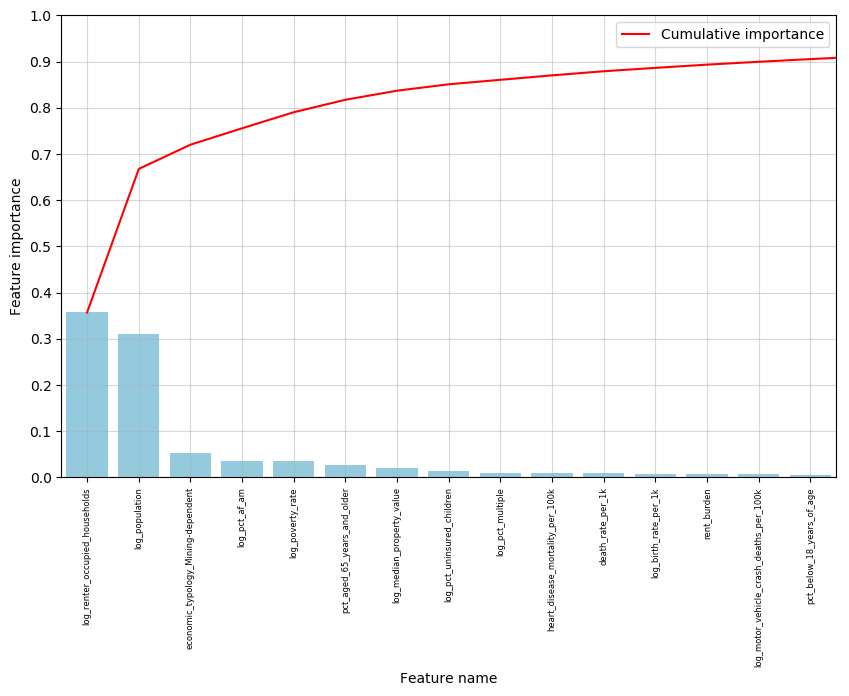

In [71]:
plt.figure(figsize=(10,6));
plt.plot(feat_import_df.loc[:15,'Feature name'].values, feat_import_df.loc[:15,'Cumulative importance'].values,
         c='r', label='Cumulative importance')
sns.barplot(x='Feature name', y='Feature importance', data=feat_import_df.iloc[:15,:], color='skyblue');

plt.grid(alpha=0.5)
plt.ylim(0.0, 1.0)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(np.round(np.linspace(0,1,11), 1), np.round(np.linspace(0,1,11), 1))
plt.legend(loc='best');

**Select most important features**

In [72]:
most_imp_feats = feat_import_df.iloc[:25, 0].values

<br>
<br>

**Fit on most important features**

In [73]:
train_data_tranf = train_data.copy()

pos_skewed_feat_names = ['log_'+str(col) for col in pos_skewed_feats]
train_data_tranf[pos_skewed_feat_names] = np.log1p(train_data_tranf[pos_skewed_feats])
train_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

test_data_tranf = test_data.copy()
test_data_tranf[pos_skewed_feat_names] = np.log1p(test_data_tranf[pos_skewed_feats])
test_data_tranf.drop(columns=pos_skewed_feats, inplace=True)

train_data_tranf = pd.get_dummies(train_data_tranf, drop_first=True)
test_data_tranf = pd.get_dummies(test_data_tranf, drop_first=True)

In [74]:
train_data_tranf = train_data_tranf.loc[:,most_imp_feats.tolist()]
test_data_tranf = test_data_tranf.loc[:,most_imp_feats.tolist()]

In [75]:
feat_labels = train_data_tranf.columns.tolist()
X_train = train_data_tranf.values
X_test = test_data_tranf.values
y_train = train_labels['evictions'].values

<br>
<br>

In [76]:
sample_weights = np.ones_like(y_train)

sample_weights[np.argwhere(y_train<1)] += 1
sample_weights[np.argwhere(y_train<2)] += 1
sample_weights[np.argwhere(y_train<7)] += 1
sample_weights[np.argwhere(y_train<16)] += 1
sample_weights[np.argwhere(y_train<29)] += 1
sample_weights[np.argwhere(y_train<60)] += 1
sample_weights[np.argwhere(y_train<109)] += 1
sample_weights[np.argwhere(y_train<226)] += 1
sample_weights[np.argwhere(y_train<676)] += 1

#sample_weights[np.argwhere(y_train<29252)] += 1

sample_weights[np.argwhere(y_train>16000)] += 150

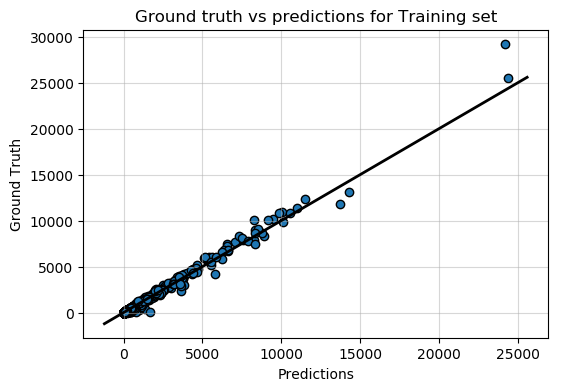

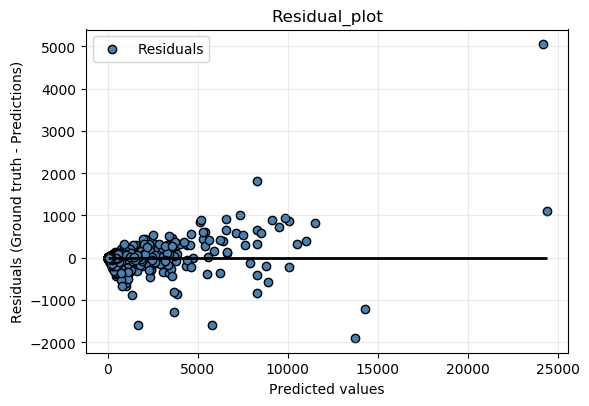

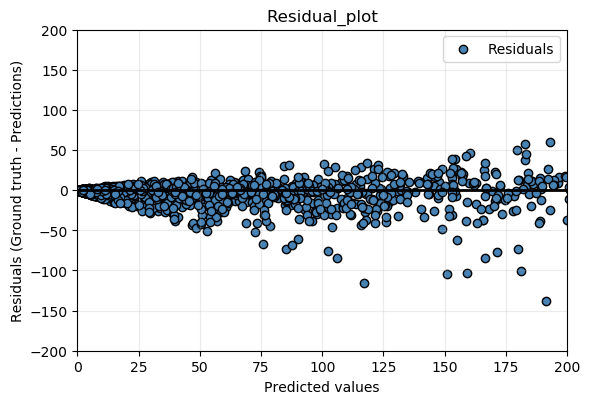

In [77]:
rand_forest = RandomForestRegressor(n_estimators=750, 
                                    criterion='mse', 
                                    max_depth=20, 
                                    n_jobs=3,)

rand_forest.fit(X_train, y_train, sample_weights)

y_pred_train = rand_forest.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')

plt.xlim(0, 200)
plt.ylim(-200,200)

plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [78]:
#from sklearn.model_selection import cross_val_score
#cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
#print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

In [79]:
y_pred_test_rf1 = rand_forest.predict(X_test)

<br>
<br>

**XGBoost**

In [80]:
train_labels['evictions'].quantile(1.0)

29251.0

In [81]:
from xgboost import XGBRegressor

In [82]:
sample_weights = np.ones_like(y_train)

sample_weights[np.argwhere(y_train<1)] += 1
sample_weights[np.argwhere(y_train<2)] += 1
sample_weights[np.argwhere(y_train<7)] += 1
sample_weights[np.argwhere(y_train<16)] += 1
sample_weights[np.argwhere(y_train<29)] += 1
sample_weights[np.argwhere(y_train<60)] += 1
sample_weights[np.argwhere(y_train<109)] += 1
sample_weights[np.argwhere(y_train<226)] += 1
sample_weights[np.argwhere(y_train<676)] += 1
sample_weights[np.argwhere(y_train<29252)] += 1

#sample_weights[np.argwhere(y_train>16000)] += 0

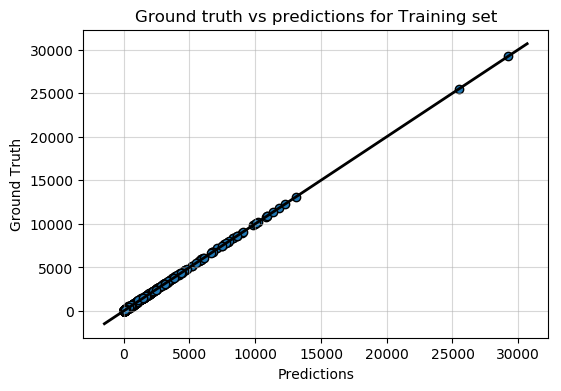

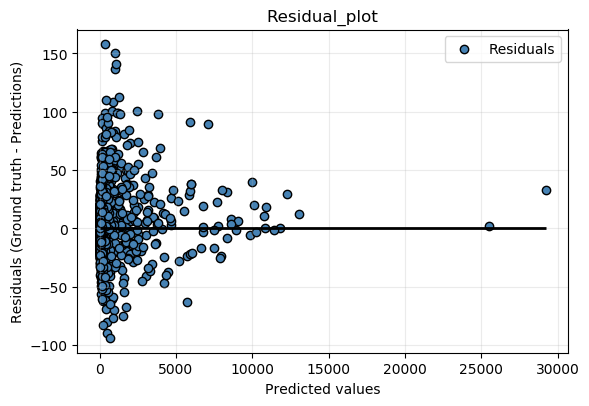

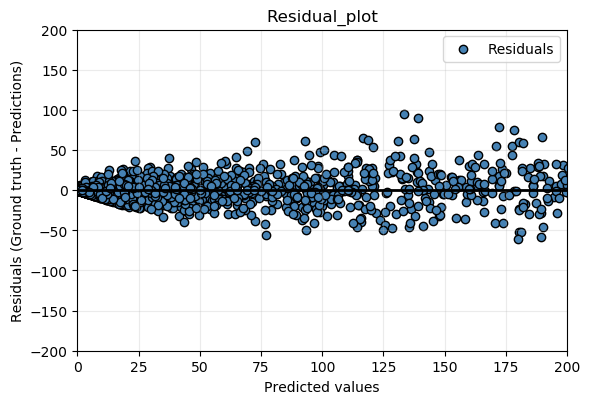

In [83]:
xgb_regr = XGBRegressor(learning_rate=0.03, 
                        n_estimators=400,
                        max_depth=7,
                        #reg_lambda=1,
                        n_jobs=4)

xgb_regr.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_train = xgb_regr.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')

plt.xlim(0, 200)
plt.ylim(-200,200)

plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [84]:
#from sklearn.model_selection import cross_val_score

#cvs = cross_val_score(xgb_regr, X_train, y_train, scoring='r2', cv=10, n_jobs=1)

#print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

# R2: 0.899 +/- 0.067

In [85]:
y_pred_test_xgb = xgb_regr.predict(X_test)

<br>
<br>

**Random Forest 2**

In [86]:
sample_weights = np.ones_like(y_train)

sample_weights[np.argwhere(y_train<1)] += 1
sample_weights[np.argwhere(y_train<2)] += 1
sample_weights[np.argwhere(y_train<7)] += 1
sample_weights[np.argwhere(y_train<16)] += 1
sample_weights[np.argwhere(y_train<29)] += 1
sample_weights[np.argwhere(y_train<60)] += 1
sample_weights[np.argwhere(y_train<109)] += 1
sample_weights[np.argwhere(y_train<226)] += 1
sample_weights[np.argwhere(y_train<676)] += 1

#sample_weights[np.argwhere(y_train<29252)] += 1

sample_weights[np.argwhere(y_train>16000)] += 150

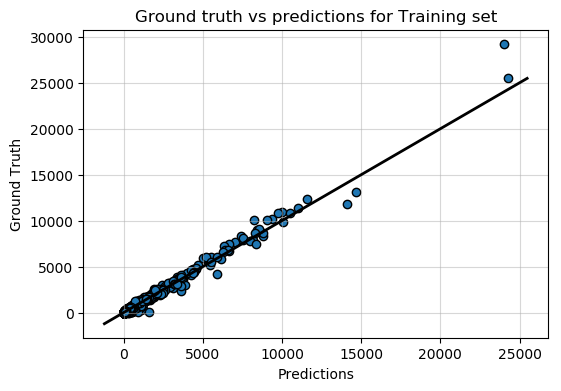

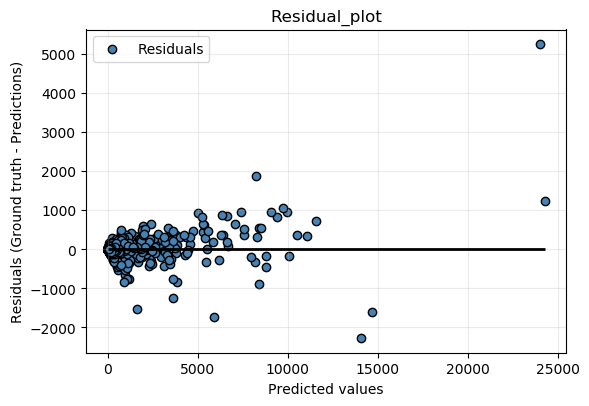

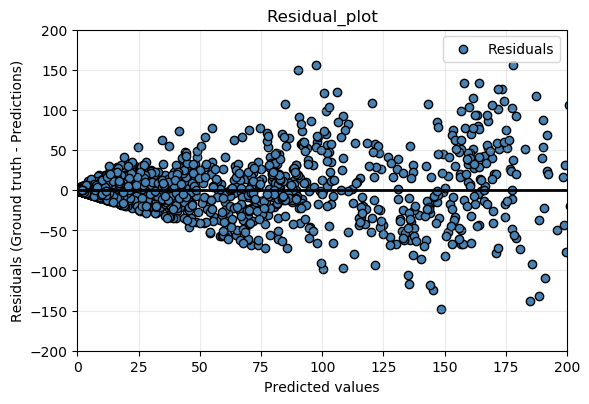

In [87]:
rand_forest2 = RandomForestRegressor(n_estimators=1500, 
                                    criterion='mse', 
                                    max_depth=10, 
                                    n_jobs=3,)

rand_forest2.fit(X_train, y_train, sample_weights)

y_pred_train = rand_forest2.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')

plt.xlim(0, 200)
plt.ylim(-200,200)

plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [88]:
#from sklearn.model_selection import cross_val_score
#cvs = cross_val_score(rand_forest, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
#print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

In [89]:
y_pred_test_rf2 = rand_forest2.predict(X_test)

<br>
<br>

<br>
<br>

**Extra Trees**

In [90]:
sample_weights = np.ones_like(y_train)

sample_weights[np.argwhere(y_train<1)] += 1
sample_weights[np.argwhere(y_train<2)] += 1
sample_weights[np.argwhere(y_train<7)] += 1
sample_weights[np.argwhere(y_train<16)] += 1
sample_weights[np.argwhere(y_train<29)] += 1
sample_weights[np.argwhere(y_train<60)] += 1
sample_weights[np.argwhere(y_train<109)] += 1
sample_weights[np.argwhere(y_train<226)] += 1
sample_weights[np.argwhere(y_train<676)] += 1
sample_weights[np.argwhere(y_train<29252)] += 1

#sample_weights[np.argwhere(y_train>16000)] += 150

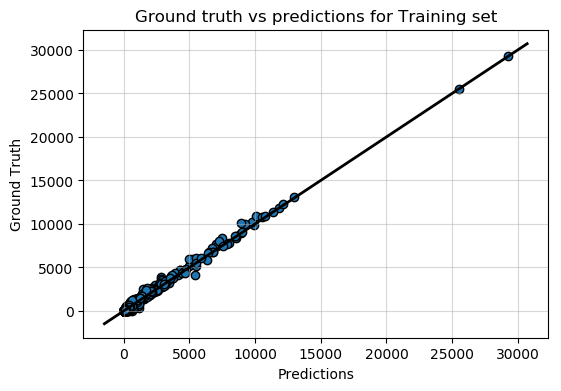

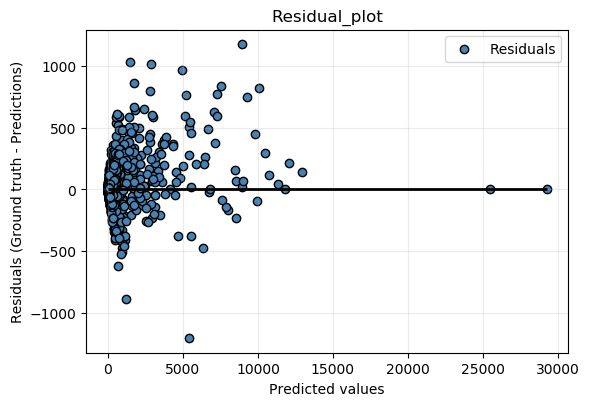

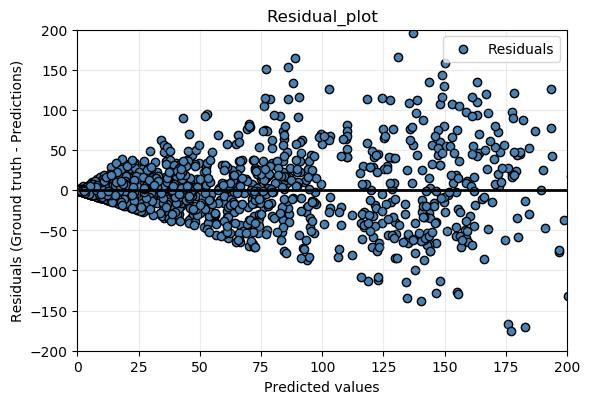

In [91]:
from sklearn.ensemble import ExtraTreesRegressor
extra_trees = ExtraTreesRegressor(n_estimators=2000, 
                                  criterion='mse', 
                                  max_depth=9, 
                                  n_jobs=3,)

extra_trees.fit(X_train, y_train, sample_weights)

y_pred_train = extra_trees.predict(X_train)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train, edgecolor='k')

plt.title("Ground truth vs predictions for Training set")
plt.xlabel("Predictions");
plt.ylabel("Ground Truth");
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x, color='k', lw=2)
plt.grid(alpha=0.5)

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

plt.figure(figsize=(6,4))
plt.scatter(y_pred_train, y_train-y_pred_train,
            c='steelblue', marker='o', edgecolor='k',
            label='Residuals')
plt.xlim(0, 200)
plt.ylim(-200,200)
plt.xlabel('Predicted values');
plt.ylabel('Residuals (Ground truth - Predictions)');
plt.legend(loc='best');
plt.grid(alpha=0.25);
plt.tight_layout();
plt.title("Residual_plot");
plt.hlines(0, np.min(y_pred_train), np.max(y_pred_train), color='k', lw=2);

In [92]:
#from sklearn.model_selection import cross_val_score
#cvs = cross_val_score(extra_trees, X_train, y_train, scoring='r2', cv=10, n_jobs=2)
#print('R2: {:.3f} +/- {:.3f}'.format(np.mean(cvs), np.std(cvs)))

In [93]:
y_pred_test_et = extra_trees.predict(X_test)

<br>
<br>

**Get submission**

In [94]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(2546, 25)
(2546,)
(2420, 25)


In [95]:
print(y_pred_test_rf1)
print(y_pred_test_rf2)
print(y_pred_test_xgb)
print(y_pred_test_et)

[1009.164       217.69964103    1.75164126 ...  562.57163041  245.41626741
  374.358     ]
[997.15681772 206.16610527   1.15416512 ... 524.20748837 231.58253929
 354.07393713]
[956.7805    272.0883      3.1081014 ... 482.65005   213.89551
 286.60138  ]
[804.45246819 236.09640832   1.92352374 ... 625.54370857 228.89864853
 339.08229202]


<br>
<br>

In [96]:
y_pred_test = (y_pred_test_rf1 + y_pred_test_rf2 + y_pred_test_xgb + y_pred_test_et)/4

In [97]:
submission = pd.DataFrame(test_row_id)
submission['evictions'] = np.clip(y_pred_test.astype(int), 0, None)
submission['evictions']

0        941
1        233
2          1
3         15
4        183
5        319
6          3
7        116
8       1941
9         45
10      2365
11        24
12        62
13         3
14        35
15      1886
16       427
17        12
18        49
19        12
20        87
21      1159
22         0
23        24
24       436
25        15
26       505
27         8
28         4
29      2314
        ... 
2390      15
2391      91
2392      75
2393      11
2394       2
2395     235
2396      13
2397     658
2398       1
2399       1
2400       0
2401       1
2402      22
2403      47
2404      39
2405       3
2406      11
2407       1
2408       7
2409      47
2410      45
2411      15
2412      20
2413     129
2414      14
2415      91
2416      85
2417     548
2418     229
2419     338
Name: evictions, Length: 2420, dtype: int32

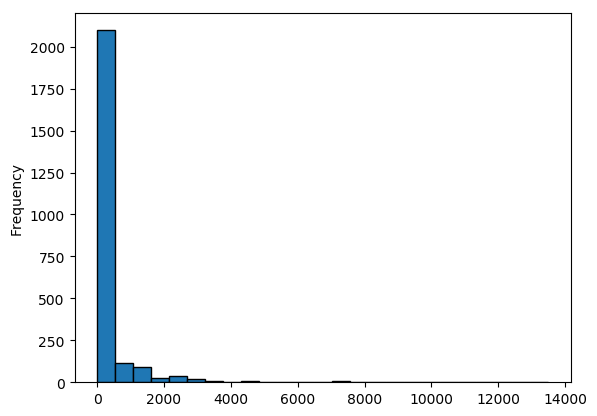

In [98]:
submission['evictions'].plot.hist(bins=25, edgecolor='k')

In [99]:
submission.to_csv("3_25012019_submission.csv", index=False)

**0.8091**

<br>
<br>

**Stack?**

In [ ]:
rand_forest1 = RandomForestRegressor(n_estimators=750, 
                                    criterion='mse', 
                                    max_depth=20, 
                                    n_jobs=3,)

xgb_regr = XGBRegressor(learning_rate=0.03, 
                        n_estimators=200,
                        max_depth=7,
                        n_jobs=4)

rand_forest2 = RandomForestRegressor(n_estimators=1500, 
                                    criterion='mse', 
                                    max_depth=10, 
                                    n_jobs=3,)

lgb_regr = LGBMRegressor(boosting_type='gbdt',
                         learning_rate=0.05, 
                         n_estimators=400,
                         max_depth=10,
                         #reg_lambda=100,
                         n_jobs=4)

extra_trees = ExtraTreesRegressor(n_estimators=1000, 
                                  criterion='mse', 
                                  max_depth=15, 
                                  n_jobs=3,)

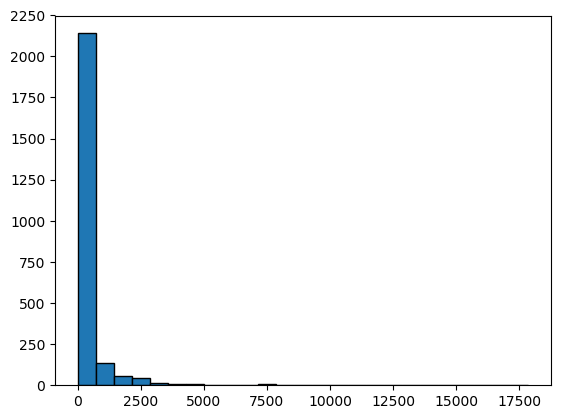

In [191]:
plt.hist(y_pred_test_rf1, bins=25, edgecolor='k');